In [ ]:
import numpy as np
import argparse
import os
import imp
import re
import pickle
import datetime
import random
import math
import logging
import copy
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import kneighbors_graph

from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence

import torch
from torch import nn
import torch.nn.utils.rnn as rnn_utils
from torch.utils import data
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn import Parameter

from itertools import chain

from utils import utils
from utils.readers import InHospitalMortalityReader
from utils.preprocessing import Discretizer, Normalizer
from utils import metrics
from utils import common_utils

## Define Model

In [ ]:
def get_loss(y_pred, y_true):
    loss = torch.nn.BCELoss()
    return loss(y_pred, y_true)

In [ ]:
def get_re_loss(y_pred, y_true):
    loss = torch.nn.MSELoss()
    return loss(y_pred, y_true)

In [4]:
def get_kl_loss(x_pred, x_target):
    loss = torch.nn.KLDivLoss(reduce=True, size_average=True)
    return loss(x_pred, x_target)

In [5]:
def get_wass_dist(x_pred, x_target):
    m1 = torch.mean(x_pred, dim=0)
    m2 = torch.mean(x_target, dim=0)
    v1 = torch.var(x_pred, dim=0)
    v2 = torch.var(x_target, dim=0)
    p1 = torch.sum(torch.pow((m1 - m2), 2))
    p2 = torch.sum(torch.pow(torch.pow(v1, 1/2) - torch.pow(v2, 1/2), 2))
    return torch.pow(p1+p2, 1/2)

In [ ]:
def pad_sents(sents, pad_token):

    sents_padded = []

    max_length = max([len(_) for _ in sents])
    for i in sents:
        padded = list(i) + [pad_token]*(max_length-len(i))
        sents_padded.append(np.array(padded))


    return np.array(sents_padded)

In [ ]:
x = [[[1, 1], [2, 2], 3], [4, 5, 6]]
y = [[7,8,9],[10,11,12]]

x+y

In [ ]:
def batch_iter_mask(x_covid, y_covid, mask_covid, lens_covid, x_spain, y_spain, mask_spain, lens_spain, batch_size, shuffle = False):
    """ Yield batches of source and target sentences reverse sorted by length (largest to smallest).
    @param data (list of (src_sent, tgt_sent)): list of tuples containing source and target sentence
    @param batch_size (int): batch size
    @param shuffle (boolean): whether to randomly shuffle the dataset
    """
    
    x = x_covid + x_spain
    y = y_covid + y_spain
    mask = mask_covid + mask_spain
    lens = lens_covid + lens_spain
    
    batch_num = math.ceil(len(x) / batch_size) # 向下取整
    index_array = list(range(len(x)))

    if shuffle:
        np.random.seed(1234)
        np.random.shuffle(index_array)

    for i in range(batch_num):
        indices = index_array[i * batch_size: (i + 1) * batch_size] #  fetch out all the induces
        
        examples = []
        for idx in indices:
            examples.append((x[idx], y[idx], mask[idx], lens[idx]))
       
        examples = sorted(examples, key=lambda e: len(e[0]), reverse=True)
    
        batch_x = [e[0] for e in examples]
        batch_y = [e[1] for e in examples]
        batch_mask_x = [e[2] for e in examples]
#         batch_name = [e[2] for e in examples]
        batch_lens = [e[3] for e in examples]

        yield batch_x, batch_y, batch_mask_x, batch_lens

In [ ]:
def batch_iter_mask_validation(x_covid, y_covid, mask_covid, lens_covid, batch_size, shuffle = False):
    """ Yield batches of source and target sentences reverse sorted by length (largest to smallest).
    @param data (list of (src_sent, tgt_sent)): list of tuples containing source and target sentence
    @param batch_size (int): batch size
    @param shuffle (boolean): whether to randomly shuffle the dataset
    """
    
    x = x_covid
    y = y_covid
    mask = mask_covid
    lens = lens_covid
    
    batch_num = math.ceil(len(x) / batch_size) # 向下取整
    index_array = list(range(len(x)))

    if shuffle:
        np.random.seed(1234)
        np.random.shuffle(index_array)

    for i in range(batch_num):
        indices = index_array[i * batch_size: (i + 1) * batch_size] #  fetch out all the induces
        
        examples = []
        for idx in indices:
            examples.append((x[idx], y[idx], mask[idx], lens[idx]))
       
        examples = sorted(examples, key=lambda e: len(e[0]), reverse=True)
    
        batch_x = [e[0] for e in examples]
        batch_y = [e[1] for e in examples]
        batch_mask_x = [e[2] for e in examples]
#         batch_name = [e[2] for e in examples]
        batch_lens = [e[3] for e in examples]

        yield batch_x, batch_y, batch_mask_x, batch_lens

In [10]:
# def batch_iter_mask(x_covid, y_covid, mask_covid, lens_covid, x_spain, y_spain, mask_spain, lens_spain, batch_size, shuffle = False):
#     """ Yield batches of source and target sentences reverse sorted by length (largest to smallest).
#     @param data (list of (src_sent, tgt_sent)): list of tuples containing source and target sentence
#     @param batch_size (int): batch size
#     @param shuffle (boolean): whether to randomly shuffle the dataset
#     """
#     batch_num_spain = math.ceil(len(x_spain) / batch_size) # 向下取整
#     batch_num_covid = math.ceil(len(x_covid) / batch_size) # 向下取整
#     batch_num = min(batch_num_spain, batch_num_covid)
    
#     index_array_covid = list(range(len(x_covid)))
#     index_array_spain = list(range(len(x_spain)))

#     if shuffle:
#         np.random.seed(1234)
#         np.random.shuffle(index_array_covid)
#         np.random.shuffle(index_array_spain)

#     for i in range(batch_num):
#         indices = index_array_covid[i * batch_size: (i + 1) * batch_size] #  fetch out all the induces
        
#         examples = []
#         for idx in indices:
#             examples.append((x_covid[idx], y_covid[idx], mask_covid[idx], lens_covid[idx]))
       
#         examples = sorted(examples, key=lambda e: len(e[0]), reverse=True)
    
#         batch_x_covid = [e[0] for e in examples]
#         batch_y_covid = [e[1] for e in examples]
#         batch_mask_x_covid = [e[2] for e in examples]
# #         batch_name = [e[2] for e in examples]
#         batch_lens_covid = [e[3] for e in examples]
    
#         indices = index_array_spain[i * batch_size: (i + 1) * batch_size] #  fetch out all the induces
        
#         examples = []
#         for idx in indices:
#             examples.append((x_spain[idx], y_spain[idx], mask_spain[idx], lens_spain[idx]))
       
#         examples = sorted(examples, key=lambda e: len(e[0]), reverse=True)
    
#         batch_x_spain = [e[0] for e in examples]
#         batch_y_spain = [e[1] for e in examples]
#         batch_mask_x_spain = [e[2] for e in examples]
# #         batch_name = [e[2] for e in examples]
#         batch_lens_spain = [e[3] for e in examples]
    
    
    
    
    

#         yield batch_x_covid, batch_y_covid, batch_mask_x_covid, batch_lens_covid, batch_x_spain, batch_y_spain, batch_mask_x_spain, batch_lens_spain     

In [ ]:
def batch_iter(x_challenge, y_challenge, lens_challenge, x_covid, y_covid, lens_covid, batch_size, shuffle=False):
    """ Yield batches of source and target sentences reverse sorted by length (largest to smallest).
    @param data (list of (src_sent, tgt_sent)): list of tuples containing source and target sentence
    @param batch_size (int): batch size
    @param shuffle (boolean): whether to randomly shuffle the dataset
    """
    batch_num_challenge = math.ceil(len(x_challenge) / batch_size) # 向下取整
    batch_num_covid = math.ceil(len(x_covid) / batch_size) # 向下取整
    
    print(batch_num_challenge, " ", batch_num_covid)
    
    batch_num = max(batch_num_challenge, batch_num_covid)
    
    index_array_challenge = list(range(len(x_challenge)))
    
    index_array_covid = list(range(len(x_covid)))

    if shuffle:
        np.random.seed(1234)
        np.random.shuffle(index_array_challenge)
        np.random.shuffle(index_array_covid)
    

    for i in range(batch_num):
        #     get challenge batch
        if (i + 1 > batch_num_challenge):
            batch_x_challenge = []
            batch_y_challenge = []
            batch_lens_challenge = []
        else:
            indices = index_array_challenge[i * batch_size: (i + 1) * batch_size]
            examples = []
            for idx in indices:
                examples.append((x_challenge[idx], y_challenge[idx], lens_challenge[idx]))
            examples = sorted(examples, key=lambda e: len(e[0]), reverse=True)
            
            batch_x_challenge = [e[0] for e in examples]
            batch_y_challenge = [e[1] for e in examples]
            batch_lens_challenge = [e[2] for e in examples]
        #     get coivd
        if (i + 1 > batch_num_covid):
            batch_x_covid = []
            batch_y_covid = []
            batch_lens_covid = []
        else:
            indices = index_array_covid[i * batch_size: (i + 1) * batch_size]
            examples = []
            for idx in indices:
                examples.append((x_covid[idx], y_covid[idx], lens_covid[idx]))
            examples = sorted(examples, key=lambda e: len(e[0]), reverse=True)
            
            batch_x_covid = [e[0] for e in examples]
            batch_y_covid = [e[1] for e in examples]
            batch_lens_covid = [e[2] for e in examples]

        yield batch_x_challenge, batch_x_covid, batch_y_challenge, batch_y_covid, batch_lens_challenge, batch_lens_covid





In [ ]:
def batch_iter_validation(x_challenge, y_challenge, lens_challenge, x_covid, y_covid, lens_covid, batch_size, shuffle=False):
    """ Yield batches of source and target sentences reverse sorted by length (largest to smallest).
    @param data (list of (src_sent, tgt_sent)): list of tuples containing source and target sentence
    @param batch_size (int): batch size
    @param shuffle (boolean): whether to randomly shuffle the dataset
    """
    batch_num_challenge = math.ceil(len(x_challenge) / batch_size) # 向下取整
    batch_num_covid = math.ceil(len(x_covid) / batch_size) # 向下取整
    
    print(batch_num_challenge, " ", batch_num_covid)
    
    batch_num = min(batch_num_challenge, batch_num_covid)
    
    index_array_challenge = list(range(len(x_challenge)))
    
    index_array_covid = list(range(len(x_covid)))

    if shuffle:
        np.random.seed(1234)
        np.random.shuffle(index_array_challenge)
        np.random.shuffle(index_array_covid)
    

    for i in range(batch_num):
        #     get challenge batch
        if (i + 1 > batch_num_challenge):
            batch_x_challenge = []
            batch_y_challenge = []
            batch_lens_challenge = []
        else:
            indices = index_array_challenge[i * batch_size: (i + 1) * batch_size]
            examples = []
            for idx in indices:
                examples.append((x_challenge[idx], y_challenge[idx], lens_challenge[idx]))
            examples = sorted(examples, key=lambda e: len(e[0]), reverse=True)
            
            batch_x_challenge = [e[0] for e in examples]
            batch_y_challenge = [e[1] for e in examples]
            batch_lens_challenge = [e[2] for e in examples]
        #     get coivd
        if (i + 1 > batch_num_covid):
            batch_x_covid = []
            batch_y_covid = []
            batch_lens_covid = []
        else:
            indices = index_array_covid[i * batch_size: (i + 1) * batch_size]
            examples = []
            for idx in indices:
                examples.append((x_covid[idx], y_covid[idx], lens_covid[idx]))
            examples = sorted(examples, key=lambda e: len(e[0]), reverse=True)
            
            batch_x_covid = [e[0] for e in examples]
            batch_y_covid = [e[1] for e in examples]
            batch_lens_covid = [e[2] for e in examples]
        
        yield batch_x_challenge, batch_x_covid, batch_y_challenge, batch_y_covid, batch_lens_challenge, batch_lens_covid


In [ ]:
def length_to_mask(length, max_len=None, dtype=None):
    """length: B.
    return B x max_len.
    If max_len is None, then max of length will be used.
    """
    assert len(length.shape) == 1, 'Length shape should be 1 dimensional.'
    max_len = max_len or length.max().item()
    mask = torch.arange(max_len, device=length.device,
                        dtype=length.dtype).expand(len(length), max_len) < length.unsqueeze(1)
    if dtype is not None:
        mask = torch.as_tensor(mask, dtype=dtype, device=length.device)
    return mask

In [ ]:
class SingleAttention(nn.Module):
    def __init__(self, attention_input_dim, attention_hidden_dim, attention_type='add', demographic_dim=12, time_aware=False, use_demographic=False):
        super(SingleAttention, self).__init__()
        
        self.attention_type = attention_type
        self.attention_hidden_dim = attention_hidden_dim
        self.attention_input_dim = attention_input_dim
        self.use_demographic = use_demographic
        self.demographic_dim = demographic_dim
        self.time_aware = time_aware

        # batch_time = torch.arange(0, batch_mask.size()[1], dtype=torch.float32).reshape(1, batch_mask.size()[1], 1)
        # batch_time = batch_time.repeat(batch_mask.size()[0], 1, 1)
        
        if attention_type == 'add':
            if self.time_aware == True:
                # self.Wx = nn.Parameter(torch.randn(attention_input_dim+1, attention_hidden_dim))
                self.Wx = nn.Parameter(torch.randn(attention_input_dim, attention_hidden_dim))
                self.Wtime_aware = nn.Parameter(torch.randn(1, attention_hidden_dim))
                nn.init.kaiming_uniform_(self.Wtime_aware, a=math.sqrt(5))
            else:
                self.Wx = nn.Parameter(torch.randn(attention_input_dim, attention_hidden_dim))
            self.Wt = nn.Parameter(torch.randn(attention_input_dim, attention_hidden_dim))
            self.Wd = nn.Parameter(torch.randn(demographic_dim, attention_hidden_dim))
            self.bh = nn.Parameter(torch.zeros(attention_hidden_dim,))
            self.Wa = nn.Parameter(torch.randn(attention_hidden_dim, 1))
            self.ba = nn.Parameter(torch.zeros(1,))
            
            nn.init.kaiming_uniform_(self.Wd, a=math.sqrt(5))
            nn.init.kaiming_uniform_(self.Wx, a=math.sqrt(5))
            nn.init.kaiming_uniform_(self.Wt, a=math.sqrt(5))
            nn.init.kaiming_uniform_(self.Wa, a=math.sqrt(5))
        elif attention_type == 'mul':
            self.Wa = nn.Parameter(torch.randn(attention_input_dim, attention_input_dim))
            self.ba = nn.Parameter(torch.zeros(1,))
            
            nn.init.kaiming_uniform_(self.Wa, a=math.sqrt(5))
        elif attention_type == 'concat':
            if self.time_aware == True:
                self.Wh = nn.Parameter(torch.randn(2*attention_input_dim+1, attention_hidden_dim))
            else:
                self.Wh = nn.Parameter(torch.randn(2*attention_input_dim, attention_hidden_dim))

            self.Wa = nn.Parameter(torch.randn(attention_hidden_dim, 1))
            self.ba = nn.Parameter(torch.zeros(1,))
            
            nn.init.kaiming_uniform_(self.Wh, a=math.sqrt(5))
            nn.init.kaiming_uniform_(self.Wa, a=math.sqrt(5))
        else:
            raise RuntimeError('Wrong attention type.')
        
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax()
    
    def forward(self, input, demo=None):
 
        batch_size, time_step, input_dim = input.size() # batch_size * time_step * hidden_dim(i)
        #assert(input_dim == self.input_dim)

        # time_decays = torch.zeros((time_step,time_step)).to(device)# t*t
        # for this_time in range(time_step):
        #     for pre_time in range(time_step):
        #         if pre_time > this_time:
        #             break
        #         time_decays[this_time][pre_time] = torch.tensor(this_time - pre_time, dtype=torch.float32).to(device)
        # b_time_decays = tile(time_decays, 0, batch_size).view(batch_size,time_step,time_step).unsqueeze(-1).to(device)# b t t 1

        time_decays = torch.tensor(range(time_step-1,-1,-1), dtype=torch.float32).unsqueeze(-1).unsqueeze(0).to(device)# 1*t*1
        b_time_decays = time_decays.repeat(batch_size,1,1)# b t 1
        
        if self.attention_type == 'add': #B*T*I  @ H*I
            q = torch.matmul(input[:,-1,:], self.Wt)# b h
            q = torch.reshape(q, (batch_size, 1, self.attention_hidden_dim)) #B*1*H
            if self.time_aware == True:
                # k_input = torch.cat((input, time), dim=-1)
                k = torch.matmul(input, self.Wx)#b t h
                # k = torch.reshape(k, (batch_size, 1, time_step, self.attention_hidden_dim)) #B*1*T*H
                time_hidden = torch.matmul(b_time_decays, self.Wtime_aware)#  b t h
            else:
                k = torch.matmul(input, self.Wx)# b t h
                # k = torch.reshape(k, (batch_size, 1, time_step, self.attention_hidden_dim)) #B*1*T*H
            if self.use_demographic == True:
                d = torch.matmul(demo, self.Wd) #B*H
                d = torch.reshape(d, (batch_size, 1, self.attention_hidden_dim)) # b 1 h
            h = q + k + self.bh # b t h
            if self.time_aware == True:
                h += time_hidden
            h = self.tanh(h) #B*T*H
            e = torch.matmul(h, self.Wa) + self.ba #B*T*1
            e = torch.reshape(e, (batch_size, time_step))# b t
        elif self.attention_type == 'mul':
            e = torch.matmul(input[:,-1,:], self.Wa)#b i
            e = torch.matmul(e.unsqueeze(1), input.permute(0,2,1)).squeeze() + self.ba #b t
        elif self.attention_type == 'concat':
            q = input[:,-1,:].unsqueeze(1).repeat(1,time_step,1)# b t i
            k = input
            c = torch.cat((q, k), dim=-1) #B*T*2I
            if self.time_aware == True:
                c = torch.cat((c, b_time_decays), dim=-1) #B*T*2I+1
            h = torch.matmul(c, self.Wh)
            h = self.tanh(h)
            e = torch.matmul(h, self.Wa) + self.ba #B*T*1
            e = torch.reshape(e, (batch_size, time_step)) # b t 
        
        # e = torch.exp(e - torch.max(e, dim=-1, keepdim=True).values)
        
        # if self.attention_width is not None:
        #     if self.history_only:
        #         lower = torch.arange(0, time_step).to(device) - (self.attention_width - 1)
        #     else:
        #         lower = torch.arange(0, time_step).to(device) - self.attention_width // 2
        #     lower = lower.unsqueeze(-1)
        #     upper = lower + self.attention_width
        #     indices = torch.arange(0, time_step).unsqueeze(0).to(device)
        #     e = e * (lower <= indices).float() * (indices < upper).float()
        
        # s = torch.sum(e, dim=-1, keepdim=True)
        # mask = subsequent_mask(time_step).to(device) # 1 t t 下三角
        # scores = e.masked_fill(mask == 0, -1e9)# b t t 下三角
        a = self.softmax(e) #B*T
        v = torch.matmul(a.unsqueeze(1), input).squeeze() #B*I

        return v, a

class FinalAttentionQKV(nn.Module):
    def __init__(self, attention_input_dim, attention_hidden_dim, attention_type='add', dropout=None):
        super(FinalAttentionQKV, self).__init__()
        
        self.attention_type = attention_type
        self.attention_hidden_dim = attention_hidden_dim
        self.attention_input_dim = attention_input_dim


        self.W_q = nn.Linear(attention_input_dim, attention_hidden_dim)
        self.W_k = nn.Linear(attention_input_dim, attention_hidden_dim)
        self.W_v = nn.Linear(attention_input_dim, attention_hidden_dim)

        self.W_out = nn.Linear(attention_hidden_dim, 1)

        self.b_in = nn.Parameter(torch.zeros(1,))
        self.b_out = nn.Parameter(torch.zeros(1,))

        nn.init.kaiming_uniform_(self.W_q.weight, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.W_k.weight, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.W_v.weight, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.W_out.weight, a=math.sqrt(5))

        self.Wh = nn.Parameter(torch.randn(2*attention_input_dim, attention_hidden_dim))
        self.Wa = nn.Parameter(torch.randn(attention_hidden_dim, 1))
        self.ba = nn.Parameter(torch.zeros(1,))
        self.rate = nn.Parameter(torch.ones(126))
        
        nn.init.kaiming_uniform_(self.Wh, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.Wa, a=math.sqrt(5))
        
        self.dropout = nn.Dropout(p=dropout)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, input, mask=None):
 
        batch_size, time_step, input_dim = input.size() # batch_size * input_dim + 1 * hidden_dim(i)
        input_q = self.W_q(torch.mean(input, dim=1)) # b h
        input_k = self.W_k(input)# b t h
        input_v = self.W_v(input)# b t h
        zeta_original = 0
        decay_term = 0

        if self.attention_type == 'add': #B*T*I  @ H*I

            q = torch.reshape(input_q, (batch_size, 1, self.attention_hidden_dim)) #B*1*H
            h = q + input_k + self.b_in # b t h
            h = self.tanh(h) #B*T*H
            e = self.W_out(h) # b t 1
            e = torch.reshape(e, (batch_size, time_step))# b t

        elif self.attention_type == 'mul':
            q = torch.reshape(input_q, (batch_size, self.attention_hidden_dim, 1)) #B*h 1
#             print('q: ', q.size())
#             print('k: ', input_k.size())
            
            dot_product = torch.matmul(input_k, q).squeeze()#b t
#             print('dot_product: ', dot_product.size())
            
            
            
            time_miss = torch.log(1 + (1 - self.sigmoid(dot_product)) * (mask.squeeze()))
#             print('time_miss: ', time_miss.size())
#             print('rate: ', self.rate)

            zeta_original = dot_product
            decay_term = self.rate * time_miss
            
            e = dot_product - decay_term
#             print('e: ', e.size())
            
            
        elif self.attention_type == 'concat':
            q = input_q.unsqueeze(1).repeat(1,time_step,1)# b t h
            k = input_k
            c = torch.cat((q, k), dim=-1) #B*T*2I
            h = torch.matmul(c, self.Wh)
            h = self.tanh(h)
            e = torch.matmul(h, self.Wa) + self.ba #B*T*1
            e = torch.reshape(e, (batch_size, time_step)) # b t 
        
#         if mask is not None:
#             e = e.masked_fill(mask == 0, -1e9)
        
        # 检查 q × k 是否会出现负数
        
        a = self.softmax(e) #B*T
        if self.dropout is not None:
            a = self.dropout(a)
        v = torch.matmul(a.unsqueeze(1), input_v).squeeze() #B*I

        return v, a, zeta_original, decay_term

def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

def tile(a, dim, n_tile):
    init_dim = a.size(dim)
    repeat_idx = [1] * a.dim()
    repeat_idx[dim] = n_tile
    a = a.repeat(*(repeat_idx))
    order_index = torch.LongTensor(np.concatenate([init_dim * np.arange(n_tile) + i for i in range(init_dim)])).to(device)
    return torch.index_select(a, dim, order_index).to(device)

class PositionwiseFeedForward(nn.Module): # new added
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x)))), None

# class PositionwiseFeedForwardConv(nn.Module):

#     def __init__(self, model_dim=512, ffn_dim=2048, dropout=0.0):
#         super(PositionalWiseFeedForward, self).__init__()
#         self.w1 = nn.Conv1d(model_dim, ffn_dim, 1)
#         self.w2 = nn.Conv1d(model_dim, ffn_dim, 1)
#         self.dropout = nn.Dropout(dropout)
#         self.layer_norm = nn.LayerNorm(model_dim)

#     def forward(self, x):
#         output = x.transpose(1, 2)
#         output = self.w2(F.relu(self.w1(output)))
#         output = self.dropout(output.transpose(1, 2))

#         # add residual and norm layer
#         output = self.layer_norm(x + output)
#         return output

class PositionalEncoding(nn.Module): # new added / not use anymore
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=400):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0., max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0., d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0 # 下三角矩阵

def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)# b h t d_k
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k) # b h t t
    if mask is not None:# 1 1 t t
        scores = scores.masked_fill(mask == 0, -1e9)# b h t t 下三角
    p_attn = F.softmax(scores, dim = -1)# b h t t
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn # b h t v (d_k) 
    
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, self.d_k * self.h), 3)
        self.final_linear = nn.Linear(d_model, d_model)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1) # 1 1 t t

        nbatches = query.size(0)# b
        input_dim = query.size(1)# i+1
        feature_dim = query.size(-1)# i+1

        #input size -> # batch_size * d_input * hidden_dim
        
        # d_model => h * d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))] # b num_head d_input d_k
        
       
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)# b num_head d_input d_v (d_k) 

        #Str DeCov
        # DeCov_contexts = x.transpose(1, 2).transpose(0, 1).transpose(1, 2).transpose(2, 3)#d_input num_head d_v b (d_k) 
        # DeCov_between_loss = torch.tensor(0.0, dtype = torch.float32, device = device)
        # DeCov_inside_loss = torch.tensor(0.0, dtype = torch.float32, device = device)
        # for input_idx in range(input_dim):
        #     current_input = DeCov_contexts[input_idx,:,:,:]
        #     for i in range(self.h):
        #         for j in range(self.h):
        #             if i == j:
        #                 covs = cov(current_input[i,:,:])
        #                 DeCov_inside_loss += 0.5 * (torch.norm(covs, p = 'fro')**2)  
        #                 #print(DeCov_inside_loss)
        #             else:
        #                 Vstack_context = torch.cat((current_input[i,:,:],current_input[j,:,:]) ,0)# 2*d_v b
        #                 assert(Vstack_context.size(0) == 2*self.d_k)
        #                 assert(Vstack_context.size(1) == nbatches)
        #                 overflow_covs = cov(Vstack_context)[self.d_k:,:]
        #                 covs = overflow_covs[:,:self.d_k]
        #                 DeCov_between_loss += 0.5 * (torch.norm(covs, p = 'fro')**2) 
        #                 #print(DeCov_between_loss)
        # DeCov_loss = DeCov_between_loss + 0.1 * DeCov_inside_loss
        #print(DeCov_loss)


      
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)# batch_size * d_input * hidden_dim

        #DeCov 
        DeCov_contexts = x.transpose(0, 1).transpose(1, 2) # I+1 H B
#         print(DeCov_contexts.shape)
        Covs = cov(DeCov_contexts[0,:,:])
        DeCov_loss = 0.5 * (torch.norm(Covs, p = 'fro')**2 - torch.norm(torch.diag(Covs))**2 ) 
        for i in range(11 -1):
            Covs = cov(DeCov_contexts[i+1,:,:])
            DeCov_loss += 0.5 * (torch.norm(Covs, p = 'fro')**2 - torch.norm(torch.diag(Covs))**2 ) 


        return self.final_linear(x), DeCov_loss

class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-7):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

def cov(m, y=None):
    if y is not None:
        m = torch.cat((m, y), dim=0)
    m_exp = torch.mean(m, dim=1)
    x = m - m_exp[:, None]
    cov = 1 / (x.size(1) - 1) * x.mm(x.t())
    return cov

class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        returned_value = sublayer(self.norm(x))
        return x + self.dropout(returned_value[0]) , returned_value[1]

class concare_mtl(nn.Module):
    def __init__(self, input_dim, hidden_dim, d_model,  MHD_num_head, d_ff, output_dim, keep_prob=0.5):
        super(concare_mtl, self).__init__()

        # hyperparameters
        self.input_dim = input_dim  
        self.hidden_dim = hidden_dim  # d_model
        self.d_model = d_model
        self.MHD_num_head = MHD_num_head
        self.d_ff = d_ff
        self.output_dim = output_dim
        self.keep_prob = keep_prob

        # layers
        self.PositionalEncoding = PositionalEncoding(self.d_model, dropout = 0, max_len = 400)

        self.GRUs = clones(nn.GRU(1, self.hidden_dim, batch_first = True), self.input_dim)
        self.LastStepAttentions = clones(SingleAttention(self.hidden_dim, 8, attention_type='concat', demographic_dim=12, time_aware=True, use_demographic=False),self.input_dim)
        
        self.FinalAttentionQKV = FinalAttentionQKV(self.hidden_dim, self.hidden_dim, attention_type='mul',dropout = 1 - self.keep_prob)

        self.MultiHeadedAttention = MultiHeadedAttention(self.MHD_num_head, self.d_model,dropout = 1 - self.keep_prob)
        self.SublayerConnection = SublayerConnection(self.d_model, dropout = 1 - self.keep_prob)

        self.PositionwiseFeedForward = PositionwiseFeedForward(self.d_model, self.d_ff, dropout=0.1)

        self.demo_proj_main = nn.Linear(12, self.hidden_dim)
        self.demo_proj = nn.Linear(12, self.hidden_dim)
        self.output_challenge = nn.Linear(self.hidden_dim, self.output_dim)
        self.output_covid = nn.Linear(self.hidden_dim, self.output_dim)
        
        self.dropout = nn.Dropout(p = 1 - self.keep_prob)
        self.FC_embed = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.tanh=nn.Tanh()
        self.softmax = nn.Softmax()
        self.sigmoid_challenge = nn.Sigmoid()
        self.sigmoid_covid = nn.Sigmoid()
        self.relu=nn.ReLU()

    def forward(self, input_challenge, input_covid, lens_challenge, lens_covid):
        # input shape [batch_size, timestep, feature_dim]
#         demo_main = self.tanh(self.demo_proj_main(demo_input)).unsqueeze(1)# b hidden_dim

        batch_size = input_challenge.size(0)
        time_step = input_challenge.size(1)
        feature_dim = input_challenge.size(2)
        assert(feature_dim == self.input_dim)# input Tensor : 256 * 48 * 76
        assert(self.d_model % self.MHD_num_head == 0)
        
#         challenge extract
        if(input_challenge.size(0) > 0):
            GRU_embeded_input = self.GRUs[0](pack_padded_sequence(input_challenge[:,:,0].unsqueeze(-1), lens_challenge, batch_first=True))[1].squeeze().unsqueeze(1) # b 1 h
            for i in range(feature_dim-1):
                embeded_input = self.GRUs[i+1](pack_padded_sequence(input_challenge[:,:,i+1].unsqueeze(-1), lens_challenge, batch_first=True))[1].squeeze().unsqueeze(1) # b 1 h
                GRU_embeded_input = torch.cat((GRU_embeded_input, embeded_input), 1)

            posi_input = self.dropout(GRU_embeded_input) # batch_size * d_input * hidden_dim


            contexts = self.SublayerConnection(posi_input, lambda x: self.MultiHeadedAttention(posi_input, posi_input, posi_input, None))# # batch_size * d_input * hidden_dim

            DeCov_loss = contexts[1]
            contexts = contexts[0]

            contexts = self.SublayerConnection(contexts, lambda x: self.PositionwiseFeedForward(contexts))[0]# # batch_size * d_input * hidden_dim

            weighted_contexts_challenge = self.FinalAttentionQKV(contexts)[0]
            
            output_challenge = self.output_challenge(self.dropout(weighted_contexts_challenge))# b 1
            output_challenge = self.sigmoid_challenge(output_challenge)
        else:
            output_challenge =  torch.tensor([])
        

#         covid extract
        if(input_covid.size(0) > 0):
            GRU_embeded_input = self.GRUs[0](pack_padded_sequence(input_covid[:,:,0].unsqueeze(-1), lens_covid, batch_first=True))[1].squeeze().unsqueeze(1) # b 1 h
            for i in range(feature_dim-1):
                embeded_input = self.GRUs[i+1](pack_padded_sequence(input_covid[:,:,i+1].unsqueeze(-1), lens_covid, batch_first=True))[1].squeeze().unsqueeze(1) # b 1 h
                GRU_embeded_input = torch.cat((GRU_embeded_input, embeded_input), 1)

            posi_input = self.dropout(GRU_embeded_input) # batch_size * d_input * hidden_dim


            contexts = self.SublayerConnection(posi_input, lambda x: self.MultiHeadedAttention(posi_input, posi_input, posi_input, None))# # batch_size * d_input * hidden_dim

            DeCov_loss = contexts[1]
            contexts = contexts[0]

            contexts = self.SublayerConnection(contexts, lambda x: self.PositionwiseFeedForward(contexts))[0]# # batch_size * d_input * hidden_dim

            weighted_contexts_covid = self.FinalAttentionQKV(contexts)[0]
#             output_embed = self.FC_embed(weighted_contexts_covid)
            output_covid = self.output_covid(self.dropout(weighted_contexts_covid))# b 1
#             output_covid = self.sigmoid_covid(output_covid)
        else:
            output_covid =  torch.tensor([])
    
        return output_challenge, output_covid, DeCov_loss
    #, self.MultiHeadedAttention.attn




In [ ]:
class mlt_mc_target(nn.Module):
    def __init__(self, cell='gru', input_dim=18, hidden_dim=32, output_dim=1, dropout=0.0):
        super(mlt_mc_target, self).__init__()
        self.cell = cell
        self.input_dim = input_dim
#         if self.use_demo:
#             self.input_dim += demo_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.dropout = dropout
        
        
        self.num_classes = 2
        self.prototype_shape = (10 * self.num_classes, 
                                self.hidden_dim)
        self.num_prototypes = self.prototype_shape[0]
        self.prototype_vectors = nn.Parameter(torch.rand(prototype_shape), requires_grad=True)
        
        self.Q = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.K = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.out = nn.Linear(self.num_prototypes, 1)
        self.relu = nn.LeakyReLU()
        
        
#         self.model = nn.GRU(self.input_dim, self.hidden_dim, batch_first = True)
        self.GRUs = clones(nn.GRU(1, self.hidden_dim, batch_first=True), self.input_dim)

        
        for i in range(32, 45):
            for p in self.GRUs[i].parameters():
                p.requires_grad=False
        
        
        self.FinalAttentionQKV = FinalAttentionQKV(self.hidden_dim, self.hidden_dim, attention_type='mul',dropout = dropout)
        self.output = nn.Linear(self.num_prototypes, self.output_dim)

        
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, input, mask, lens):
        batch_size = input.size(0)
        time_step = input.size(1)
        feature_dim = input.size(2)
#         print("feature_dim: ", feature_dim)


        GRU_embeded_input = self.GRUs[0](pack_padded_sequence(input[:, :, 0].unsqueeze(-1), lens.cpu(), batch_first=True))[1].squeeze().unsqueeze(1) # b 1 h
        for i in range(feature_dim - 1):
            embeded_input = \
            self.GRUs[i + 1](pack_padded_sequence(input[:, :, i + 1].unsqueeze(-1), lens.cpu(), batch_first=True))[1].squeeze().unsqueeze(1) # b 1 h
            GRU_embeded_input = torch.cat((GRU_embeded_input, embeded_input), 1)

        posi_input = self.dropout(GRU_embeded_input)  # batch_size * d_input * hidden_dim
        posi_input, attn, zeta_original, decay_term = self.FinalAttentionQKV(posi_input,mask)
        
        distance = self.attention_similarity(posi_input, batch_size)  # b, p, d
        print(distance)
        output = self.output(distance)
#         output = self.sigmoid(output)
        return output, attn, posi_input, zeta_original, decay_term
        
    def get_last_shared_layer(self):
        return self.GRUs
                
    def attention_similarity(self, x, batch_size):
        x1 = x.unsqueeze(1).repeat(1, self.num_prototypes, 1)  # b, p, d
        x2 = self.prototype_vectors.unsqueeze(0).repeat(batch_size, 1, 1)  # b, p, d

        q = self.relu(self.Q(x1))  # b, p, d
        k = self.relu(self.K(x2).transpose(-1, -2))  # b, d, p
        distance = torch.matmul(q, k)  # b, p, p
        distance = self.dropout(distance)
        distance = self.out(distance).squeeze(-1)  # b, p
        return distance

## Prepare Data

In [32]:
def get_n2n_data(x, y, x_len):
    length = len(x)
    assert length == len(y)
    assert length == len(x_len)
    new_x = []
    new_y = []
    new_x_len = []
    for i in range(length):
        for j in range(len(x[i])):
            new_x.append(x[i][:j+1])
            new_y.append(y[i][j])
            new_x_len.append(j+1)
    return new_x, new_y, new_x_len

In [33]:
def get_n2n_data_mask(x, y, mask, x_len):
    length = len(x)
    assert length == len(y)
    assert length == len(x_len)
    new_x = []
    new_y = []
    new_x_len = []
    new_mask = []
    for i in range(length):
        for j in range(len(x[i])):
            new_x.append(x[i][:j+1])
            new_y.append(y[i][j])
            new_x_len.append(j+1)
            new_mask.append(mask[i][j])
    return new_x, new_y, new_mask, new_x_len

### Covid

In [34]:
# data_path_covid = './data/mtl_covid_data_regression_frontfill_challengenormalized/'
data_path_covid = './data/mtl_covid_data_regression_frontfill_challengenormalized/'

all_x_covid = pickle.load(open(data_path_covid + 'x.dat', 'rb'))
all_y_covid = pickle.load(open(data_path_covid + 'y.dat', 'rb'))
all_time_covid = pickle.load(open(data_path_covid + 'time_all.dat', 'rb'))
all_x_mask_covid = pickle.load(open(data_path_covid + 'tongji_time_mask_second.dat', 'rb'))
all_x_len_covid = [len(i) for i in all_x_covid]
subset_idx_covid_fromChallenge = [0,1,2,7,11,12,24,25,28,30,32,36,37,39,50,51,65,73]
subset_idx_challenge_fromCovid = [27,29,18,16,26,33,28,31,32,15,11,25,21,20,9,17,30,19]

covid_block5 = [50, 32, 30, 7, 51, 2, 73, 39, 37, 36, 11, 0, 24, 1, 28, 12]
covid_block2 = [25, 65]
covid_block6 = [3, 8, 21, 34, 38, 40, 41, 44, 57, 60, 62]
covid_block3 = [4, 5, 6, 9, 10, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 26, 27, 29,
 31, 33, 35, 42, 43, 45, 46, 47, 48, 49, 52, 53, 54, 55, 56, 58, 59, 61, 63, 64, 66,
 67, 68, 69, 70, 71, 72]




for i in range(len(all_x_covid)):
    cur = np.array(all_x_covid[i], dtype=float)
    cur_block5 = cur[:, covid_block5]
    cur_block2 = cur[:, covid_block2]
    cur_block6 = cur[:, covid_block6]
    cur_block3 = cur[:, covid_block3]
    
    add_block4 = [[0] * 3] * len(all_x_covid[i])
    add_block1 = [[0] * 13] * len(all_x_covid[i])
    add_block7 = [[0] * 36] * len(all_x_covid[i])
    
#     all_x_covid[i] = np.concatenate((cur_subset, cur_other), axis=1).tolist()   
    all_x_covid[i] = np.concatenate((cur_block5, cur_block2, 
                                     add_block4, cur_block6, 
                                     add_block1, cur_block3,
                                     add_block7
                                    ), axis=1).tolist()  

# get y
long_y_covid = all_time_covid
kfold_y_covid = [s[-1] for s in all_y_covid]

In [35]:
all_x_mask_global_covid = []

for i in range(len(all_x_mask_covid)):
    all_x_mask_global_covid.append([])
    cur_mask = np.array(all_x_mask_covid[i], dtype=float)
    cur_block5_mask = cur_mask[:, covid_block5]
    cur_block2_mask = cur_mask[:, covid_block2]
    cur_block6_mask = cur_mask[:, covid_block6]
    cur_block3_mask = cur_mask[:, covid_block3]
    
    add_block4_mask = [[9e9] * 3] * len(all_x_mask_covid[i])
    add_block1_mask = [[9e9] * 13] * len(all_x_mask_covid[i])
    add_block7_mask = [[9e9] * 36] * len(all_x_mask_covid[i])
    
    all_x_mask_global_covid[i] = np.concatenate((cur_block5_mask, cur_block2_mask, 
                                     add_block4_mask, cur_block6_mask, 
                                     add_block1_mask, cur_block3_mask,
                                     add_block7_mask
                                    ), axis=1).tolist()  

In [36]:
print(len(all_x_mask_global_covid))

361


### Spain

In [37]:
# data_path_spain = "./data/SpainCovid/"
data_path_spain = "./data/Spain_new/"

all_x_spain = pickle.load(open(data_path_spain + 'x.dat', 'rb'))
all_y_spain = pickle.load(open(data_path_spain + 'y.dat', 'rb'))
all_time_spain = pickle.load(open(data_path_spain + 'time_all.dat', 'rb'))
all_x_mask_spain = pickle.load(open(data_path_spain + 'spain_time_mask_second.dat', 'rb'))
all_x_len_spain = [len(i) for i in all_x_spain]

# subset_idx_spain = [0,1,2,6,12,13,16,17,20,22,23,25,31,32,33,35,43,47,48,52,53,56]
# subset_idx_spain_new = [0,1,2,6,12,13,16,17,20,22,23,25,31,32,33,35,43,47,48,52,53,56,66,67,68,69,70,71]

# subset_idx_spain_fromChallenge = [51, 47, 43, 12, 1, 48, 35, 15, 25, 53, 39, 57, 22, 26, 44, 49]
subset_idx_spain_fromChallenge = [1,2,12,15,22,25,26,35,39,43,44,47,48,49,51,53,55,65]
subset_idx_challenge_fromSpain = [28,29,33,25,19,21,14,11,9,26,22,16,32,23,18,20,17,27]            

spain_block5 = [39, 35, 23, 47, 55, 51, 22, 53, 25, 15, 43, 65, 1, 2, 48, 12]
spain_block4 = [26, 44, 49]
spain_block6 = [31, 56, 32, 20, 6, 13, 52, 0, 16, 33, 17]
spain_block7 = [3, 4, 5, 7, 8, 9, 10, 11, 14, 18, 19, 21, 24,
                27, 28, 29, 30, 34, 36, 37, 38, 40, 41, 42, 
                45, 46, 50, 54, 57, 58, 59, 60, 61, 62, 63, 64]


# for i in range(len(all_x_spain[0][0])):
#     if i not in subset_idx_spain_fromChallenge:
#         other_idx_spain.append(i)


subset_x_spain = []

for i in range(len(all_x_spain)):
    cur = np.array(all_x_spain[i], dtype=float)
    cur_block5 = cur[:, spain_block5]
    cur_block4 = cur[:, spain_block4]
    cur_block6 = cur[:, spain_block6]
    cur_block7 = cur[:, spain_block7]
    
    add_block2 = [[0] * 2] * len(all_x_spain[i])
    add_block1 = [[0] * 13] * len(all_x_spain[i])
    add_block3 = [[0] * 45] * len(all_x_spain[i])
    all_x_spain[i] = np.concatenate((cur_block5, add_block2,
                                     cur_block4, cur_block6,
                                     add_block1, add_block3,
                                     cur_block7
                                    ), axis=1).tolist()  

long_y_spain = all_time_spain

In [38]:
print(len(all_x_spain[0][0]))

126


In [39]:
all_x_mask_global_spain = []
for i in range(len(all_x_mask_spain)):
    all_x_mask_global_spain.append([])
    cur_mask = np.array(all_x_mask_spain[i], dtype=float)
    cur_block5_mask = cur_mask[:, spain_block5]
    cur_block4_mask = cur_mask[:, spain_block4]
    cur_block6_mask = cur_mask[:, spain_block6]
    cur_block7_mask = cur_mask[:, spain_block7]
    
    add_block2_mask = [[9e9] * 2] * len(all_x_mask_spain[i])
    add_block1_mask = [[9e9] * 13] * len(all_x_mask_spain[i])
    add_block3_mask = [[9e9] * 45] * len(all_x_mask_spain[i])
    
    all_x_mask_global_spain[i] = np.concatenate((cur_block5_mask, add_block2_mask,
                                     cur_block4_mask, cur_block6_mask,
                                     add_block1_mask, add_block3_mask,
                                     cur_block7_mask
                                    ), axis=1).tolist()  

In [40]:
print(len(all_x_mask_global_spain))

1891


## 准备训练

In [41]:
def transfer_gru_dict(pretrain_dict, model_dict):
    state_dict = {}
    for k, v in pretrain_dict.items():
        if 'GRUs' in k:
#             if 'GRUs.17' in k:
#                 break;
            state_dict[k] = v
            print("transfered weight: {}".format(k))
        else:
#             pass
            print("Other weight in model_dict: {}".format(k))
    return state_dict

In [42]:
#device = torch.device("cuda:0" if torch.cuda.is_available() == True else 'cpu')
device = torch.device('cuda')
print("available device: {}".format(device))

available device: cuda


In [43]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED) #numpy
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED) # cpu
torch.cuda.manual_seed(RANDOM_SEED) #gpu
torch.backends.cudnn.deterministic=True # cudnn
    
epochs = 150
batch_size = 256
input_dim = 126
hidden_dim = 32
d_model = 32
MHD_num_head = 4
d_ff = 64
output_dim = 1
dropout = 0.5

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)
# input_dim, d_model, d_k, d_v, MHD_num_head, d_ff, output_dim
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [44]:
def push_prototypes():
    global_proto_dist = np.full(model.num_prototypes, np.inf)
    global_fmap_patches = np.zeros([
            model.num_prototypes, model.prototype_shape[1]
        ])

    model.eval()
    prototype_shape = model.prototype_shape
    n_prototypes = model.num_prototypes

    h_t = None
    for step, (batch_x, batch_y, batch_x_mask, batch_lens) in enumerate(batch_iter_mask(test_x_covid, test_y_covid, test_x_mask_covid, test_x_len_covid, test_x_spain, test_y_spain, test_x_mask_spain, test_x_len_spain, batch_size, shuffle=False)):
        batch_x = torch.tensor(pad_sents(batch_x, pad_token), dtype=torch.float32).to(device)
        batch_y = torch.tensor(batch_y, dtype=torch.float32).to(device)
        batch_lens = torch.tensor(batch_lens, dtype=torch.float32).to(device).int()
        batch_x_mask = torch.tensor(pad_sents(batch_x_mask, pad_token), dtype=torch.float32).to(device)

        with torch.no_grad():
            opt, attn, h_t0, _, _ = model(batch_x, batch_x_mask, batch_lens)
        if h_t is None:
            h_t = h_t0
        else:
            h_t = torch.cat((h_t, h_t0), dim=0)

    update_prototypes_on_batch(h_t)
    prototype_update = np.reshape(global_fmap_patches,
                                  tuple(prototype_shape))
    model.prototype_vectors.data.copy_(
        torch.tensor(prototype_update, dtype=torch.float32).cuda())

def update_prototypes_on_batch(h_t):
    h_t = h_t.cpu().detach().numpy()
    h_ti = h_t.reshape((h_t.shape[0], -1))
    kmeans = KMeans(n_clusters=20)
    kmeans.fit(h_ti)
    cluster_center = kmeans.cluster_centers_.reshape((20, hidden_dim))
    global_fmap_patches = cluster_center

In [139]:
from sklearn.cluster import KMeans
epochs = 150
batch_size = 256

fold_count = 0
total_train_loss = []
total_valid_loss = []
# global_best = 0


push_start = 10
# push_start = 0
push_epochs = [i for i in range(1000) if i % 50 == 0]
# push_epochs.append(0)
push_epochs.append(10)


global_best = 10000
global_best_challenge = 0
mse = []
mad = []
mape = []
kappa = []
auroc = []
auprc = []
minpse = []
history = []
history_challenge = []

pad_token = np.zeros(126)
pad_token_challenge = np.zeros(34)

# kfold_challenge = kfold.split(subset_x_challenge, kfold_y_challenge)
kfold_covid = kfold.split(all_x_covid, kfold_y_covid)
kfold_spain = kfold.split(all_x_spain, all_y_spain)

for i, data in enumerate(zip(kfold_covid, kfold_spain)):
    
    model = mlt_mc_target(input_dim=input_dim, output_dim=output_dim, hidden_dim=hidden_dim, dropout=dropout).to(device)
#     model = MLP(input_dim).to(device)
    
    train_covid, test_covid = data[0]
    train_spain, test_spain = data[1]
        
    
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    fold_count += 1
#     train_challenge, test_challenge = data[0]
#     train_covid, test_covid = data[1]
    
    
    

# challenge -----------------------------------------------------------------------------------------------
#     train_x_challenge = [all_x_challenge[i] for i in train_challenge]
#     train_y_challenge = [kfold_y_challenge[i] for i in train_challenge]
#     train_x_len_challenge = [all_x_len_challenge[i] for i in train_challenge]
#     train_x_challenge, train_y_challenge, train_x_len_challenge = get_n2n_data(train_x_challenge, train_y_challenge, train_x_len_challenge)
    
    
#     test_x_challenge = [all_x_challenge[i] for i in test_challenge]
#     test_y_challenge = [kfold_y_challenge[i] for i in test_challenge]
#     test_x_len_challenge = [all_x_len_challenge[i] for i in test_challenge]
#     test_x_challenge, test_y_challenge, test_x_len_challenge = get_n2n_data(test_x_challenge, test_y_challenge, test_x_len_challenge)
# end challenge -----------------------------------------------------------------------------------------------

# covid -----------------------------------------------------------------------------------------------

    train_x_covid = [all_x_covid[i] for i in train_covid]
    train_y_covid = [long_y_covid[i] for i in train_covid]
    train_x_len_covid = [all_x_len_covid[i] for i in train_covid]
    train_x_mask_covid = [all_x_mask_global_covid[i] for i in train_covid]
    train_x_covid, train_y_covid, train_x_mask_covid, train_x_len_covid = get_n2n_data_mask(train_x_covid, train_y_covid, train_x_mask_covid, train_x_len_covid)
    
    test_x_covid = [all_x_covid[i] for i in test_covid]
    test_y_covid = [long_y_covid[i] for i in test_covid]
    test_x_len_covid = [all_x_len_covid[i] for i in test_covid]
    test_x_mask_covid = [all_x_mask_global_covid[i] for i in test_covid]
    test_x_covid, test_y_covid, test_x_mask_covid, test_x_len_covid = get_n2n_data_mask(test_x_covid, test_y_covid, test_x_mask_covid, test_x_len_covid)
# end covid -----------------------------------------------------------------------------------------------

# spain -----------------------------------------------------------------------------------------------
    train_x_spain = [all_x_spain[i] for i in train_spain]
    train_y_spain = [long_y_spain[i] for i in train_spain]
    train_x_len_spain = [all_x_len_spain[i] for i in train_spain]
    train_x_mask_spain = [all_x_mask_global_spain[i] for i in train_spain]
    train_x_spain, train_y_spain, train_x_mask_spain, train_x_len_spain = get_n2n_data_mask(train_x_spain, train_y_spain, train_x_mask_spain, train_x_len_spain)
    
    
    test_x_spain = [all_x_spain[i] for i in test_spain]
    test_y_spain = [long_y_spain[i] for i in test_spain]
    test_x_len_spain = [all_x_len_spain[i] for i in test_spain]
    test_x_mask_spain = [all_x_mask_global_spain[i] for i in test_spain]
    test_x_spain, test_y_spain, test_x_mask_spain, test_x_len_spain = get_n2n_data_mask(test_x_spain, test_y_spain, test_x_mask_spain, test_x_len_spain)
# end spain -----------------------------------------------------------------------------------------------

    
    file_name = './model/MTFed_prototype5_spain_covid_timeaware_second/mc-prototype-time-' + str(fold_count)
    
    fold_train_loss = []
    fold_valid_loss = []
    best_micro_roc = 0
    best_macro_roc = 0
    best_micro_f1 = 0
    best_macro_f1 = 0
    best_acc = 0
    best_auroc = 0
    best_auprc = 0
    best_minpse = 0
    best_f1 = 0
    best_mse = 10000
    best_mad = 0
    best_mape = 0
    best_kappa = 0
    
    for each_epoch in range(epochs):
        epoch_loss = []
        counter_batch = 0
        model.train()
        for step, (batch_x, batch_y, batch_x_mask, batch_lens) in enumerate(batch_iter_mask(train_x_covid, train_y_covid, train_x_mask_covid, train_x_len_covid, train_x_spain, train_y_spain, train_x_mask_spain, train_x_len_spain, batch_size, shuffle=True)):
            optimizer.zero_grad()
            batch_x = torch.tensor(pad_sents(batch_x, pad_token), dtype=torch.float32).to(device)
            batch_y = torch.tensor(batch_y, dtype=torch.float32).to(device)
            batch_lens = torch.tensor(batch_lens, dtype=torch.float32).int().cpu()
#             batch_lens = torch.tensor(batch_lens, dtype=torch.float32).to(device).int()
            batch_x_mask = torch.tensor(pad_sents(batch_x_mask, pad_token), dtype=torch.float32).to(device)
            opt, attn, _, _, _ = model(batch_x, batch_x_mask, batch_lens)
            MSE_Loss = get_re_loss(opt, batch_y.unsqueeze(-1))
            
            loss = MSE_Loss
            epoch_loss.append(loss.cpu().detach().numpy())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 20)
            optimizer.step()
            
            
            
            if step % 20 == 0:
                print('Fold %d Epoch %d Batch %d: Train Loss = %.4f'%(fold_count,each_epoch, step, loss.cpu().detach().numpy()))
        epoch_loss = np.mean(epoch_loss)
        fold_train_loss.append(epoch_loss)
        
#       Validation
        y_true = []
        y_pred = []
        y_pred_flatten = []
        y_true_flatten = []
        
        y_true_challenge = []
        y_pred_challenge = []
        y_pred_flatten_challenge = []
        y_true_flatten_challenge = []
        
#         covid validation
        with torch.no_grad():
            model.eval()
            valid_loss = []
            valid_true = []
            valid_pred = []
            
            valid_loss_challenge = []
            valid_true_challenge = []
            valid_pred_challenge = []
            
            for step, (batch_x, batch_y, batch_x_mask, batch_lens) in enumerate(batch_iter_mask(test_x_covid, test_y_covid, test_x_mask_covid, test_x_len_covid, test_x_spain, test_y_spain, test_x_mask_spain, test_x_len_spain, batch_size, shuffle=True)):
                 
                batch_x = torch.tensor(pad_sents(batch_x, pad_token), dtype=torch.float32).to(device)
                batch_y = torch.tensor(batch_y, dtype=torch.float32).to(device)
                batch_lens = torch.tensor(batch_lens, dtype=torch.float32).int().cpu()
#                 batch_lens = torch.tensor(batch_lens, dtype=torch.float32).to(device).int()
                batch_x_mask = torch.tensor(pad_sents(batch_x_mask, pad_token), dtype=torch.float32).to(device)
                
                opt, attn, _, _, _ = model(batch_x, batch_x_mask, batch_lens)
                MSE_Loss = get_re_loss(opt, batch_y.unsqueeze(-1))
                
                valid_loss.append(MSE_Loss.cpu().detach().numpy())
                
                y_pred_flatten += list(opt.cpu().detach().numpy().flatten())
                y_true_flatten += list(batch_y.cpu().numpy().flatten())
         
            valid_loss = np.mean(valid_loss)
            fold_valid_loss.append(valid_loss)
            ret = metrics.print_metrics_regression(y_true_flatten, y_pred_flatten, verbose=0)
            history.append(ret)
            
            if each_epoch % 10 == 0:
                print('Fold %d, epoch %d: Loss = %.4f Valid loss = %.4f MSE = %.4f' % (
                    fold_count, each_epoch, fold_train_loss[-1], fold_valid_loss[-1], ret['mse']), flush=True)
                metrics.print_metrics_regression(y_true_flatten, y_pred_flatten)
            
            cur_mse = ret['mse']
            if cur_mse < best_mse:
                best_mse = cur_mse
                best_mad = ret['mad']
                best_mape = ret['mape']
                best_kappa = ret['kappa']
                state = {
                    'net': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'epoch': each_epoch
                }
                torch.save(state, file_name + '_' + str(fold_count))

                if cur_mse < global_best:
                    global_best = cur_mse
                    state = {
                        'net': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'epoch': each_epoch
                    }
                    torch.save(state, file_name)
                    print('------------ Save best model - MSE: %.4f ------------' % cur_mse, flush=True)

        print('Fold %d, mse = %.4f, mape = %.4f' % (fold_count, ret['mse'], ret['mape']), flush=True)
        
        if each_epoch >= push_start and each_epoch in push_epochs:
            push_prototypes()

    mse.append(best_mse)
    mad.append(best_mad)
    mape.append(best_mape)
    kappa.append(best_kappa)
    total_train_loss.append(fold_train_loss)
    total_valid_loss.append(fold_valid_loss)

print('mse %.4f(%.4f)' % (np.mean(mse), np.std(mse)))
print('mad %.4f(%.4f)' % (np.mean(mad), np.std(mad)))
print('mape %.4f(%.4f)' % (np.mean(mape), np.std(mape)))
print('kappa %.4f(%.4f)' % (np.mean(kappa), np.std(kappa)))

/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:213: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 0 Batch 0: Train Loss = 1280.5383


/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:213: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:213: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:213: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:213: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:213: UserWarning: Implicit dimension choice for softmax 

Fold 1 Epoch 0 Batch 20: Train Loss = 1316.3781


/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:213: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:213: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:213: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:213: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:213: UserWarning: Implicit dimension choice for softmax 

Fold 1 Epoch 0 Batch 40: Train Loss = 1247.1967


/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:213: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:213: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:213: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:213: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:213: UserWarning: Implicit dimension choice for softmax 

Fold 1, epoch 0: Loss = 1269.3812 Valid loss = 771.3034 MSE = 768.5443


/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:213: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:213: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Custom bins confusion matrix:
[[1018    0    0]
 [  62    0    0]
 [ 399    0    0]]
Mean absolute deviation (MAD) = 19.08946418762207
Mean squared error (MSE) = 768.5443115234375
Mean absolute percentage error (MAPE) = 1144.4244384765625
Cohen kappa score = 0.0
------------ Save best model - MSE: 768.5443 ------------
Fold 1, mse = 768.5443, mape = 1144.4244


/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:213: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 1 Batch 0: Train Loss = 1006.7997


/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:213: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:213: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:213: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:213: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:213: UserWarning: Implicit dimension choice for softmax 

KeyboardInterrupt: 

# 验证模型有效性

## Covid

In [46]:
epochs = 150
batch_size = 256

fold_count = 0
total_train_loss = []
total_valid_loss = []
# global_best = 0

global_best = 10000
global_best_challenge = 0
mse = []
mad = []
mape = []
kappa = []
auroc = []
auprc = []
minpse = []
history = []
history_challenge = []

pad_token = np.zeros(126)


for train_covid, test_covid in kfold.split(all_x_covid, kfold_y_covid):
    
    
    fold_count += 1
    file_name = './model/MTFed_prototype_spain_covid_timeaware_second/mc-prototype-time-'+str(fold_count)+'_'+str(fold_count)
#     model = MLP(input_dim).to(device)
    model = mlt_mc_target(input_dim=input_dim, output_dim=output_dim, hidden_dim=hidden_dim, dropout=dropout).to(device)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
    checkpoint = torch.load(file_name, map_location='cuda:0')
    model.load_state_dict(checkpoint['net'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    model.eval()
    
    
# covid -----------------------------------------------------------------------------------------------
    train_x_covid = [all_x_covid[i] for i in train_covid]
    train_y_covid = [long_y_covid[i] for i in train_covid]
    train_x_len_covid = [all_x_len_covid[i] for i in train_covid]
    train_x_mask_covid = [all_x_mask_global_covid[i] for i in train_covid]
    train_x_covid, train_y_covid, train_x_mask_covid, train_x_len_covid = get_n2n_data_mask(train_x_covid, train_y_covid, train_x_mask_covid, train_x_len_covid)
    
    test_x_covid = [all_x_covid[i] for i in test_covid]
    test_y_covid = [long_y_covid[i] for i in test_covid]
    test_x_len_covid = [all_x_len_covid[i] for i in test_covid]
    test_x_mask_covid = [all_x_mask_global_covid[i] for i in test_covid]
    test_x_covid, test_y_covid, test_x_mask_covid, test_x_len_covid = get_n2n_data_mask(test_x_covid, test_y_covid, test_x_mask_covid, test_x_len_covid)
# end covid -----------------------------------------------------------------------------------------------
    fold_train_loss = []
    fold_valid_loss = []
    best_micro_roc = 0
    best_macro_roc = 0
    best_micro_f1 = 0
    best_macro_f1 = 0
    best_acc = 0
    best_auroc = 0
    best_auprc = 0
    best_minpse = 0
    best_f1 = 0
    best_mse = 10000
    best_mad = 0
    best_mape = 0
    best_kappa = 0
        
#         Validation
    y_true = []
    y_pred = []
    y_pred_flatten = []
    y_true_flatten = []

    y_true_challenge = []
    y_pred_challenge = []
    y_pred_flatten_challenge = []
    y_true_flatten_challenge = []

    with torch.no_grad():
        model.eval()
        valid_loss = []
        valid_true = []
        valid_pred = []

        valid_loss_challenge = []
        valid_true_challenge = []
        valid_pred_challenge = []

        for step, (batch_x, batch_y, batch_x_mask, batch_lens) in enumerate(batch_iter_mask_validation(test_x_covid, test_y_covid, test_x_mask_covid, test_x_len_covid, batch_size, shuffle=True)):

            batch_x = torch.tensor(pad_sents(batch_x, pad_token), dtype=torch.float32).to(device)
            batch_y = torch.tensor(batch_y, dtype=torch.float32).to(device)
            batch_lens = torch.tensor(batch_lens, dtype=torch.float32).to(device).int()
            batch_x_mask = torch.tensor(pad_sents(batch_x_mask, pad_token), dtype=torch.float32).to(device)
            opt, attn, _, _, _ = model(batch_x, batch_x_mask, batch_lens)
            MSE_Loss = get_re_loss(opt, batch_y.unsqueeze(-1))

            valid_loss.append(MSE_Loss.cpu().detach().numpy())

            y_pred_flatten += list(opt.cpu().detach().numpy().flatten())
            y_true_flatten += list(batch_y.cpu().numpy().flatten())

        valid_loss = np.mean(valid_loss)
        fold_valid_loss.append(valid_loss)
        ret = metrics.print_metrics_regression(y_true_flatten, y_pred_flatten, verbose=0)
        history.append(ret)

        cur_mse = ret['mse']
        if cur_mse < best_mse:
            best_mse = cur_mse
            best_mad = ret['mad']
            best_mape = ret['mape']
            best_kappa = ret['kappa']

            if cur_mse < global_best:
                global_best = cur_mse

    print('Fold %d, mse = %.4f, mape = %.4f' % (fold_count, ret['mse'], ret['mape']), flush=True)

    mse.append(best_mse)
    mad.append(best_mad)
    mape.append(best_mape)
    kappa.append(best_kappa)
    total_train_loss.append(fold_train_loss)
    total_valid_loss.append(fold_valid_loss)

print('mse %.4f(%.4f)' % (np.mean(mse), np.std(mse)))
print('mad %.4f(%.4f)' % (np.mean(mad), np.std(mad)))
print('mape %.4f(%.4f)' % (np.mean(mape), np.std(mape)))
print('kappa %.4f(%.4f)' % (np.mean(kappa), np.std(kappa)))
    
    
    
    
    
    
    

/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:213: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[-10.9540, -10.9540, -10.9540,  ..., -10.9540, -10.9540, -10.9540],
        [-10.9924, -10.9924, -10.9924,  ..., -10.9924, -10.9924, -10.9924],
        [-10.9653, -10.9653, -10.9653,  ..., -10.9653, -10.9653, -10.9653],
        ...,
        [ -2.6700,  -2.6700,  -2.6700,  ...,  -2.6700,  -2.6700,  -2.6700],
        [-10.2401, -10.2401, -10.2401,  ..., -10.2401, -10.2401, -10.2401],
        [ -9.7379,  -9.7379,  -9.7379,  ...,  -9.7379,  -9.7379,  -9.7379]],
       device='cuda:0')
tensor([[-11.0506, -11.0506, -11.0506,  ..., -11.0506, -11.0506, -11.0506],
        [-10.9535, -10.9535, -10.9535,  ..., -10.9535, -10.9535, -10.9535],
        [-10.9969, -10.9969, -10.9969,  ..., -10.9969, -10.9969, -10.9969],
        ...,
        [ -2.4443,  -2.4443,  -2.4443,  ...,  -2.4443,  -2.4443,  -2.4443],
        [ -1.7332,  -1.7332,  -1.7332,  ...,  -1.7332,  -1.7332,  -1.7332],
        [ -3.5034,  -3.5034,  -3.5034,  ...,  -3.5034,  -3.5034,  -3.5034]],
       device='cuda:0')
tensor([[-10

/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:213: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[12.9209, 12.9209, 12.9209,  ..., 12.9209, 12.9209, 12.9209],
        [12.9448, 12.9448, 12.9448,  ..., 12.9448, 12.9448, 12.9448],
        [12.8536, 12.8536, 12.8536,  ..., 12.8536, 12.8536, 12.8536],
        ...,
        [10.5899, 10.5899, 10.5899,  ..., 10.5899, 10.5899, 10.5899],
        [ 8.6233,  8.6233,  8.6233,  ...,  8.6233,  8.6233,  8.6233],
        [13.2985, 13.2985, 13.2985,  ..., 13.2985, 13.2985, 13.2985]],
       device='cuda:0')
tensor([[12.9575, 12.9575, 12.9575,  ..., 12.9575, 12.9575, 12.9575],
        [12.9973, 12.9973, 12.9973,  ..., 12.9973, 12.9973, 12.9973],
        [12.9902, 12.9902, 12.9902,  ..., 12.9902, 12.9902, 12.9902],
        ...,
        [12.4711, 12.4711, 12.4711,  ..., 12.4711, 12.4711, 12.4711],
        [ 2.6506,  2.6506,  2.6506,  ...,  2.6506,  2.6506,  2.6506],
        [12.7403, 12.7403, 12.7403,  ..., 12.7403, 12.7403, 12.7403]],
       device='cuda:0')
tensor([[12.9124, 12.9124, 12.9124,  ..., 12.9124, 12.9124, 12.9124],
        [12.94

/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:213: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[11.2800, 11.2800, 11.2800,  ..., 11.2800, 11.2800, 11.2800],
        [11.2987, 11.2987, 11.2987,  ..., 11.2987, 11.2987, 11.2987],
        [11.3008, 11.3008, 11.3008,  ..., 11.3008, 11.3008, 11.3008],
        ...,
        [10.6398, 10.6398, 10.6398,  ..., 10.6398, 10.6398, 10.6398],
        [ 8.3803,  8.3803,  8.3803,  ...,  8.3803,  8.3803,  8.3803],
        [ 2.5024,  2.5024,  2.5024,  ...,  2.5024,  2.5024,  2.5024]],
       device='cuda:0')
tensor([[11.2887, 11.2887, 11.2887,  ..., 11.2887, 11.2887, 11.2887],
        [ 0.7494,  0.7494,  0.7494,  ...,  0.7494,  0.7494,  0.7494],
        [11.3126, 11.3126, 11.3126,  ..., 11.3126, 11.3126, 11.3126],
        ...,
        [11.0143, 11.0143, 11.0143,  ..., 11.0143, 11.0143, 11.0143],
        [ 2.6603,  2.6603,  2.6603,  ...,  2.6603,  2.6603,  2.6603],
        [ 1.7833,  1.7833,  1.7833,  ...,  1.7833,  1.7833,  1.7833]],
       device='cuda:0')
tensor([[11.2875, 11.2875, 11.2875,  ..., 11.2875, 11.2875, 11.2875],
        [11.30

/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:213: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[9.1470, 9.1470, 9.1470,  ..., 9.1470, 9.1470, 9.1470],
        [9.0390, 9.0390, 9.0390,  ..., 9.0390, 9.0390, 9.0390],
        [9.1971, 9.1971, 9.1971,  ..., 9.1971, 9.1971, 9.1971],
        ...,
        [1.6299, 1.6299, 1.6299,  ..., 1.6299, 1.6299, 1.6299],
        [1.5290, 1.5290, 1.5290,  ..., 1.5290, 1.5290, 1.5290],
        [9.0240, 9.0240, 9.0240,  ..., 9.0240, 9.0240, 9.0240]],
       device='cuda:0')
tensor([[8.9807, 8.9807, 8.9807,  ..., 8.9807, 8.9807, 8.9807],
        [9.1431, 9.1431, 9.1431,  ..., 9.1431, 9.1431, 9.1431],
        [8.9782, 8.9782, 8.9782,  ..., 8.9782, 8.9782, 8.9782],
        ...,
        [2.0301, 2.0301, 2.0301,  ..., 2.0301, 2.0301, 2.0301],
        [8.9049, 8.9049, 8.9049,  ..., 8.9049, 8.9049, 8.9049],
        [7.3596, 7.3596, 7.3596,  ..., 7.3596, 7.3596, 7.3596]],
       device='cuda:0')
tensor([[8.6439, 8.6439, 8.6439, 8.6439, 8.6439, 8.6439, 8.6439, 8.6439, 8.6439,
         8.6439, 8.6439, 8.6439, 8.6439, 8.6439, 8.6439, 8.6439, 8.6439, 8.

/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:213: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[-10.7067, -10.7067, -10.7067,  ..., -10.7067, -10.7067, -10.7067],
        [-10.7247, -10.7247, -10.7247,  ..., -10.7247, -10.7247, -10.7247],
        [-10.7594, -10.7594, -10.7594,  ..., -10.7594, -10.7594, -10.7594],
        ...,
        [-10.7275, -10.7275, -10.7275,  ..., -10.7275, -10.7275, -10.7275],
        [ -1.7084,  -1.7084,  -1.7084,  ...,  -1.7084,  -1.7084,  -1.7084],
        [ -2.3106,  -2.3106,  -2.3106,  ...,  -2.3106,  -2.3106,  -2.3106]],
       device='cuda:0')
tensor([[-10.7027, -10.7027, -10.7027,  ..., -10.7027, -10.7027, -10.7027],
        [-10.7013, -10.7013, -10.7013,  ..., -10.7013, -10.7013, -10.7013],
        [-10.7703, -10.7703, -10.7703,  ..., -10.7703, -10.7703, -10.7703],
        ...,
        [-10.3001, -10.3001, -10.3001,  ..., -10.3001, -10.3001, -10.3001],
        [-10.4177, -10.4177, -10.4177,  ..., -10.4177, -10.4177, -10.4177],
        [ -3.7740,  -3.7740,  -3.7740,  ...,  -3.7740,  -3.7740,  -3.7740]],
       device='cuda:0')
tensor([[-10

/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:213: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[13.4632, 13.4632, 13.4632,  ..., 13.4632, 13.4632, 13.4632],
        [13.5512, 13.5512, 13.5512,  ..., 13.5512, 13.5512, 13.5512],
        [12.2186, 12.2186, 12.2186,  ..., 12.2186, 12.2186, 12.2186],
        ...,
        [ 5.7602,  5.7602,  5.7602,  ...,  5.7602,  5.7602,  5.7602],
        [ 2.3490,  2.3490,  2.3490,  ...,  2.3490,  2.3490,  2.3490],
        [13.1570, 13.1570, 13.1570,  ..., 13.1570, 13.1570, 13.1570]],
       device='cuda:0')
tensor([[13.6174, 13.6174, 13.6174,  ..., 13.6174, 13.6174, 13.6174],
        [13.6053, 13.6053, 13.6053,  ..., 13.6053, 13.6053, 13.6053],
        [13.5504, 13.5504, 13.5504,  ..., 13.5504, 13.5504, 13.5504],
        ...,
        [ 3.3203,  3.3203,  3.3203,  ...,  3.3203,  3.3203,  3.3203],
        [ 1.0981,  1.0981,  1.0981,  ...,  1.0981,  1.0981,  1.0981],
        [13.3356, 13.3356, 13.3356,  ..., 13.3356, 13.3356, 13.3356]],
       device='cuda:0')
tensor([[13.4785, 13.4785, 13.4785,  ..., 13.4785, 13.4785, 13.4785],
        [13.59

/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:213: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[12.9067, 12.9067, 12.9067,  ..., 12.9067, 12.9067, 12.9067],
        [12.8690, 12.8690, 12.8690,  ..., 12.8690, 12.8690, 12.8690],
        [12.8571, 12.8571, 12.8571,  ..., 12.8571, 12.8571, 12.8571],
        ...,
        [ 3.5829,  3.5829,  3.5829,  ...,  3.5829,  3.5829,  3.5829],
        [ 6.6286,  6.6286,  6.6286,  ...,  6.6286,  6.6286,  6.6286],
        [ 5.6971,  5.6971,  5.6971,  ...,  5.6971,  5.6971,  5.6971]],
       device='cuda:0')
tensor([[12.9532, 12.9532, 12.9532,  ..., 12.9532, 12.9532, 12.9532],
        [12.9163, 12.9163, 12.9163,  ..., 12.9163, 12.9163, 12.9163],
        [12.8395, 12.8395, 12.8395,  ..., 12.8395, 12.8395, 12.8395],
        ...,
        [12.4794, 12.4794, 12.4794,  ..., 12.4794, 12.4794, 12.4794],
        [12.2310, 12.2310, 12.2310,  ..., 12.2310, 12.2310, 12.2310],
        [ 2.6134,  2.6134,  2.6134,  ...,  2.6134,  2.6134,  2.6134]],
       device='cuda:0')
tensor([[12.8935, 12.8935, 12.8935,  ..., 12.8935, 12.8935, 12.8935],
        [12.81

/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:213: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[-14.1772, -14.1772, -14.1772,  ..., -14.1772, -14.1772, -14.1772],
        [ -0.7773,  -0.7773,  -0.7773,  ...,  -0.7773,  -0.7773,  -0.7773],
        [ -0.8145,  -0.8145,  -0.8145,  ...,  -0.8145,  -0.8145,  -0.8145],
        ...,
        [-14.3917, -14.3917, -14.3917,  ..., -14.3917, -14.3917, -14.3917],
        [ -3.9943,  -3.9943,  -3.9943,  ...,  -3.9943,  -3.9943,  -3.9943],
        [ -1.4122,  -1.4122,  -1.4122,  ...,  -1.4122,  -1.4122,  -1.4122]],
       device='cuda:0')
tensor([[-14.1134, -14.1134, -14.1134,  ..., -14.1134, -14.1134, -14.1134],
        [-14.1142, -14.1142, -14.1142,  ..., -14.1142, -14.1142, -14.1142],
        [-13.8699, -13.8699, -13.8699,  ..., -13.8699, -13.8699, -13.8699],
        ...,
        [ -2.2888,  -2.2888,  -2.2888,  ...,  -2.2888,  -2.2888,  -2.2888],
        [-14.3113, -14.3113, -14.3113,  ..., -14.3113, -14.3113, -14.3113],
        [-14.3547, -14.3547, -14.3547,  ..., -14.3547, -14.3547, -14.3547]],
       device='cuda:0')
tensor([[ -0

/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:213: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[12.7144, 12.7144, 12.7144,  ..., 12.7144, 12.7144, 12.7144],
        [12.6645, 12.6645, 12.6645,  ..., 12.6645, 12.6645, 12.6645],
        [12.9687, 12.9687, 12.9687,  ..., 12.9687, 12.9687, 12.9687],
        ...,
        [11.1607, 11.1607, 11.1607,  ..., 11.1607, 11.1607, 11.1607],
        [13.2571, 13.2571, 13.2571,  ..., 13.2571, 13.2571, 13.2571],
        [ 3.6984,  3.6984,  3.6984,  ...,  3.6984,  3.6984,  3.6984]],
       device='cuda:0')
tensor([[12.9137, 12.9137, 12.9137,  ..., 12.9137, 12.9137, 12.9137],
        [12.0737, 12.0737, 12.0737,  ..., 12.0737, 12.0737, 12.0737],
        [12.2099, 12.2099, 12.2099,  ..., 12.2099, 12.2099, 12.2099],
        ...,
        [ 2.5281,  2.5281,  2.5281,  ...,  2.5281,  2.5281,  2.5281],
        [ 3.6808,  3.6808,  3.6808,  ...,  3.6808,  3.6808,  3.6808],
        [13.1685, 13.1685, 13.1685,  ..., 13.1685, 13.1685, 13.1685]],
       device='cuda:0')
tensor([[12.9261, 12.9261, 12.9261,  ..., 12.9261, 12.9261, 12.9261],
        [14.16

/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:213: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[-13.6352, -13.6352, -13.6352,  ..., -13.6352, -13.6352, -13.6352],
        [ -0.8306,  -0.8306,  -0.8306,  ...,  -0.8306,  -0.8306,  -0.8306],
        [ -0.8700,  -0.8700,  -0.8700,  ...,  -0.8700,  -0.8700,  -0.8700],
        ...,
        [ -2.4795,  -2.4795,  -2.4795,  ...,  -2.4795,  -2.4795,  -2.4795],
        [ -7.5976,  -7.5976,  -7.5976,  ...,  -7.5976,  -7.5976,  -7.5976],
        [ -2.4828,  -2.4828,  -2.4828,  ...,  -2.4828,  -2.4828,  -2.4828]],
       device='cuda:0')
tensor([[-13.6366, -13.6366, -13.6366,  ..., -13.6366, -13.6366, -13.6366],
        [-13.6419, -13.6419, -13.6419,  ..., -13.6419, -13.6419, -13.6419],
        [ -0.8575,  -0.8575,  -0.8575,  ...,  -0.8575,  -0.8575,  -0.8575],
        ...,
        [ -5.4059,  -5.4059,  -5.4059,  ...,  -5.4059,  -5.4059,  -5.4059],
        [-13.5336, -13.5336, -13.5336,  ..., -13.5336, -13.5336, -13.5336],
        [ -2.4495,  -2.4495,  -2.4495,  ...,  -2.4495,  -2.4495,  -2.4495]],
       device='cuda:0')
tensor([[-13

## Spain

In [45]:
epochs = 150
batch_size = 256

fold_count = 0
total_train_loss = []
total_valid_loss = []
# global_best = 0

global_best = 10000
global_best_challenge = 0
mse = []
mad = []
mape = []
kappa = []
auroc = []
auprc = []
minpse = []
history = []
history_challenge = []

pad_token = np.zeros(126)


for train_spain, test_spain in kfold.split(all_x_spain, all_y_spain):
    
    fold_count += 1
    
    file_name = './model/MTFed_prototype_spain_covid_timeaware_second/mc-prototype-time-'+str(fold_count)+'_'+str(fold_count)
    model = mlt_mc_target(input_dim=input_dim, output_dim=output_dim, hidden_dim=hidden_dim, dropout=dropout).to(device)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
    checkpoint = torch.load(file_name, map_location='cuda:0')
    model.load_state_dict(checkpoint['net'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    model.eval()
    
# spain -----------------------------------------------------------------------------------------------
    train_x_spain = [all_x_spain[i] for i in train_spain]
    train_y_spain = [long_y_spain[i] for i in train_spain]
    train_x_len_spain = [all_x_len_spain[i] for i in train_spain]
    train_x_mask_spain = [all_x_mask_global_spain[i] for i in train_spain]
    train_x_spain, train_y_spain, train_x_mask_spain, train_x_len_spain = get_n2n_data_mask(train_x_spain, train_y_spain, train_x_mask_spain, train_x_len_spain)
    
    
    test_x_spain = [all_x_spain[i] for i in test_spain]
    test_y_spain = [long_y_spain[i] for i in test_spain]
    test_x_len_spain = [all_x_len_spain[i] for i in test_spain]
    test_x_mask_spain = [all_x_mask_global_spain[i] for i in test_spain]
    test_x_spain, test_y_spain, test_x_mask_spain, test_x_len_spain = get_n2n_data_mask(test_x_spain, test_y_spain, test_x_mask_spain, test_x_len_spain)
# end spain -----------------------------------------------------------------------------------------------

    fold_train_loss = []
    fold_valid_loss = []
    best_micro_roc = 0
    best_macro_roc = 0
    best_micro_f1 = 0
    best_macro_f1 = 0
    best_acc = 0
    best_auroc = 0
    best_auprc = 0
    best_minpse = 0
    best_f1 = 0
    best_mse = 10000
    best_mad = 0
    best_mape = 0
    best_kappa = 0
        
#         Validation
    y_true = []
    y_pred = []
    y_pred_flatten = []
    y_true_flatten = []

    y_true_challenge = []
    y_pred_challenge = []
    y_pred_flatten_challenge = []
    y_true_flatten_challenge = []

    with torch.no_grad():
        model.eval()
        valid_loss = []
        valid_true = []
        valid_pred = []

        valid_loss_challenge = []
        valid_true_challenge = []
        valid_pred_challenge = []

        for step, (batch_x, batch_y, batch_x_mask, batch_lens) in enumerate(batch_iter_mask_validation(test_x_spain, test_y_spain, test_x_mask_spain, test_x_len_spain, batch_size, shuffle=True)):

            batch_x = torch.tensor(pad_sents(batch_x, pad_token), dtype=torch.float32).to(device)
            batch_y = torch.tensor(batch_y, dtype=torch.float32).to(device)
            batch_lens = torch.tensor(batch_lens, dtype=torch.float32).to(device).int()
            batch_x_mask = torch.tensor(pad_sents(batch_x_mask, pad_token), dtype=torch.float32).to(device)
            opt, attn, _ = model(batch_x, batch_x_mask, batch_lens)
            MSE_Loss = get_re_loss(opt, batch_y.unsqueeze(-1))
            valid_loss.append(MSE_Loss.cpu().detach().numpy())

            y_pred_flatten += list(opt.cpu().detach().numpy().flatten())
            y_true_flatten += list(batch_y.cpu().numpy().flatten())

        valid_loss = np.mean(valid_loss)
        fold_valid_loss.append(valid_loss)
        ret = metrics.print_metrics_regression(y_true_flatten, y_pred_flatten, verbose=0)
        history.append(ret)

        cur_mse = ret['mse']
        if cur_mse < best_mse:
            best_mse = cur_mse
            best_mad = ret['mad']
            best_mape = ret['mape']
            best_kappa = ret['kappa']

            if cur_mse < global_best:
                global_best = cur_mse

    print('Fold %d, mse = %.4f, mape = %.4f' % (fold_count, ret['mse'], ret['mape']), flush=True)

    mse.append(best_mse)
    mad.append(best_mad)
    mape.append(best_mape)
    kappa.append(best_kappa)
    total_train_loss.append(fold_train_loss)
    total_valid_loss.append(fold_valid_loss)

print('mse %.4f(%.4f)' % (np.mean(mse), np.std(mse)))
print('mad %.4f(%.4f)' % (np.mean(mad), np.std(mad)))
print('mape %.4f(%.4f)' % (np.mean(mape), np.std(mape)))
print('kappa %.4f(%.4f)' % (np.mean(kappa), np.std(kappa)))
    
    
    
    
    
    
    

/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:208: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1, mse = 272.6773, mape = 1409.2240


/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:208: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2, mse = 354.4206, mape = 1856.0593


/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:208: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3, mse = 321.0742, mape = 1797.8870


/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:208: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4, mse = 261.3399, mape = 2006.3072


/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:208: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5, mse = 290.3839, mape = 1401.5174


/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:208: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6, mse = 317.4633, mape = 1560.7398
Fold 7, mse = 306.4002, mape = 1559.3424


/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:208: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8, mse = 327.9359, mape = 1516.1785


/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:208: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:208: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9, mse = 241.6057, mape = 1603.2547


/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:208: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10, mse = 446.1715, mape = 1561.5879
mse 313.9473(54.4944)
mad 10.7153(0.8870)
mape 1627.2098(187.0574)
kappa 0.5339(0.0755)


# 输出可解释性结果

## 输出模型参数

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import patches

In [51]:
file_name = './model/MTFed_prototype_spain_covid_timeaware_second/mc-prototype-time-9'
model = mlt_mc_target(input_dim=input_dim, output_dim=output_dim, hidden_dim=hidden_dim, dropout=dropout).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
checkpoint = torch.load(file_name, map_location='cuda:0')
model.load_state_dict(checkpoint['net'])
optimizer.load_state_dict(checkpoint['optimizer'])
model.eval()

mlt_mc_target(
  (Q): Linear(in_features=32, out_features=32, bias=True)
  (K): Linear(in_features=32, out_features=32, bias=True)
  (out): Linear(in_features=20, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (GRUs): ModuleList(
    (0): GRU(1, 32, batch_first=True)
    (1): GRU(1, 32, batch_first=True)
    (2): GRU(1, 32, batch_first=True)
    (3): GRU(1, 32, batch_first=True)
    (4): GRU(1, 32, batch_first=True)
    (5): GRU(1, 32, batch_first=True)
    (6): GRU(1, 32, batch_first=True)
    (7): GRU(1, 32, batch_first=True)
    (8): GRU(1, 32, batch_first=True)
    (9): GRU(1, 32, batch_first=True)
    (10): GRU(1, 32, batch_first=True)
    (11): GRU(1, 32, batch_first=True)
    (12): GRU(1, 32, batch_first=True)
    (13): GRU(1, 32, batch_first=True)
    (14): GRU(1, 32, batch_first=True)
    (15): GRU(1, 32, batch_first=True)
    (16): GRU(1, 32, batch_first=True)
    (17): GRU(1, 32, batch_first=True)
    (18): GRU(1, 32, batch_first=True)
    (19): GRU(1,

In [52]:
model_dict = model.state_dict()
time_aware = model_dict['FinalAttentionQKV.rate'].cpu().detach().numpy().tolist()
idx_list = pickle.load(open('./sort_idx_list', 'rb'))

In [53]:
idx_list_edit = []
for name in idx_list:
    if name in idx_list_edit:
        idx_list_edit.append(name+'*')
    else:
        idx_list_edit.append(name)

In [54]:
idx_list_tongji_spain = []
time_aware_tongji_spain = []
for i, idx in enumerate(idx_list_edit):
    if i >= 31 and i < 44:
        continue
    idx_list_tongji_spain.append(idx)
    time_aware_tongji_spain.append(time_aware[i])

In [55]:
idx_list_tongji_spain = np.array(idx_list_tongji_spain)[np.argsort(time_aware_tongji_spain)]
time_aware_tongji_spain = np.sort(time_aware_tongji_spain)

/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


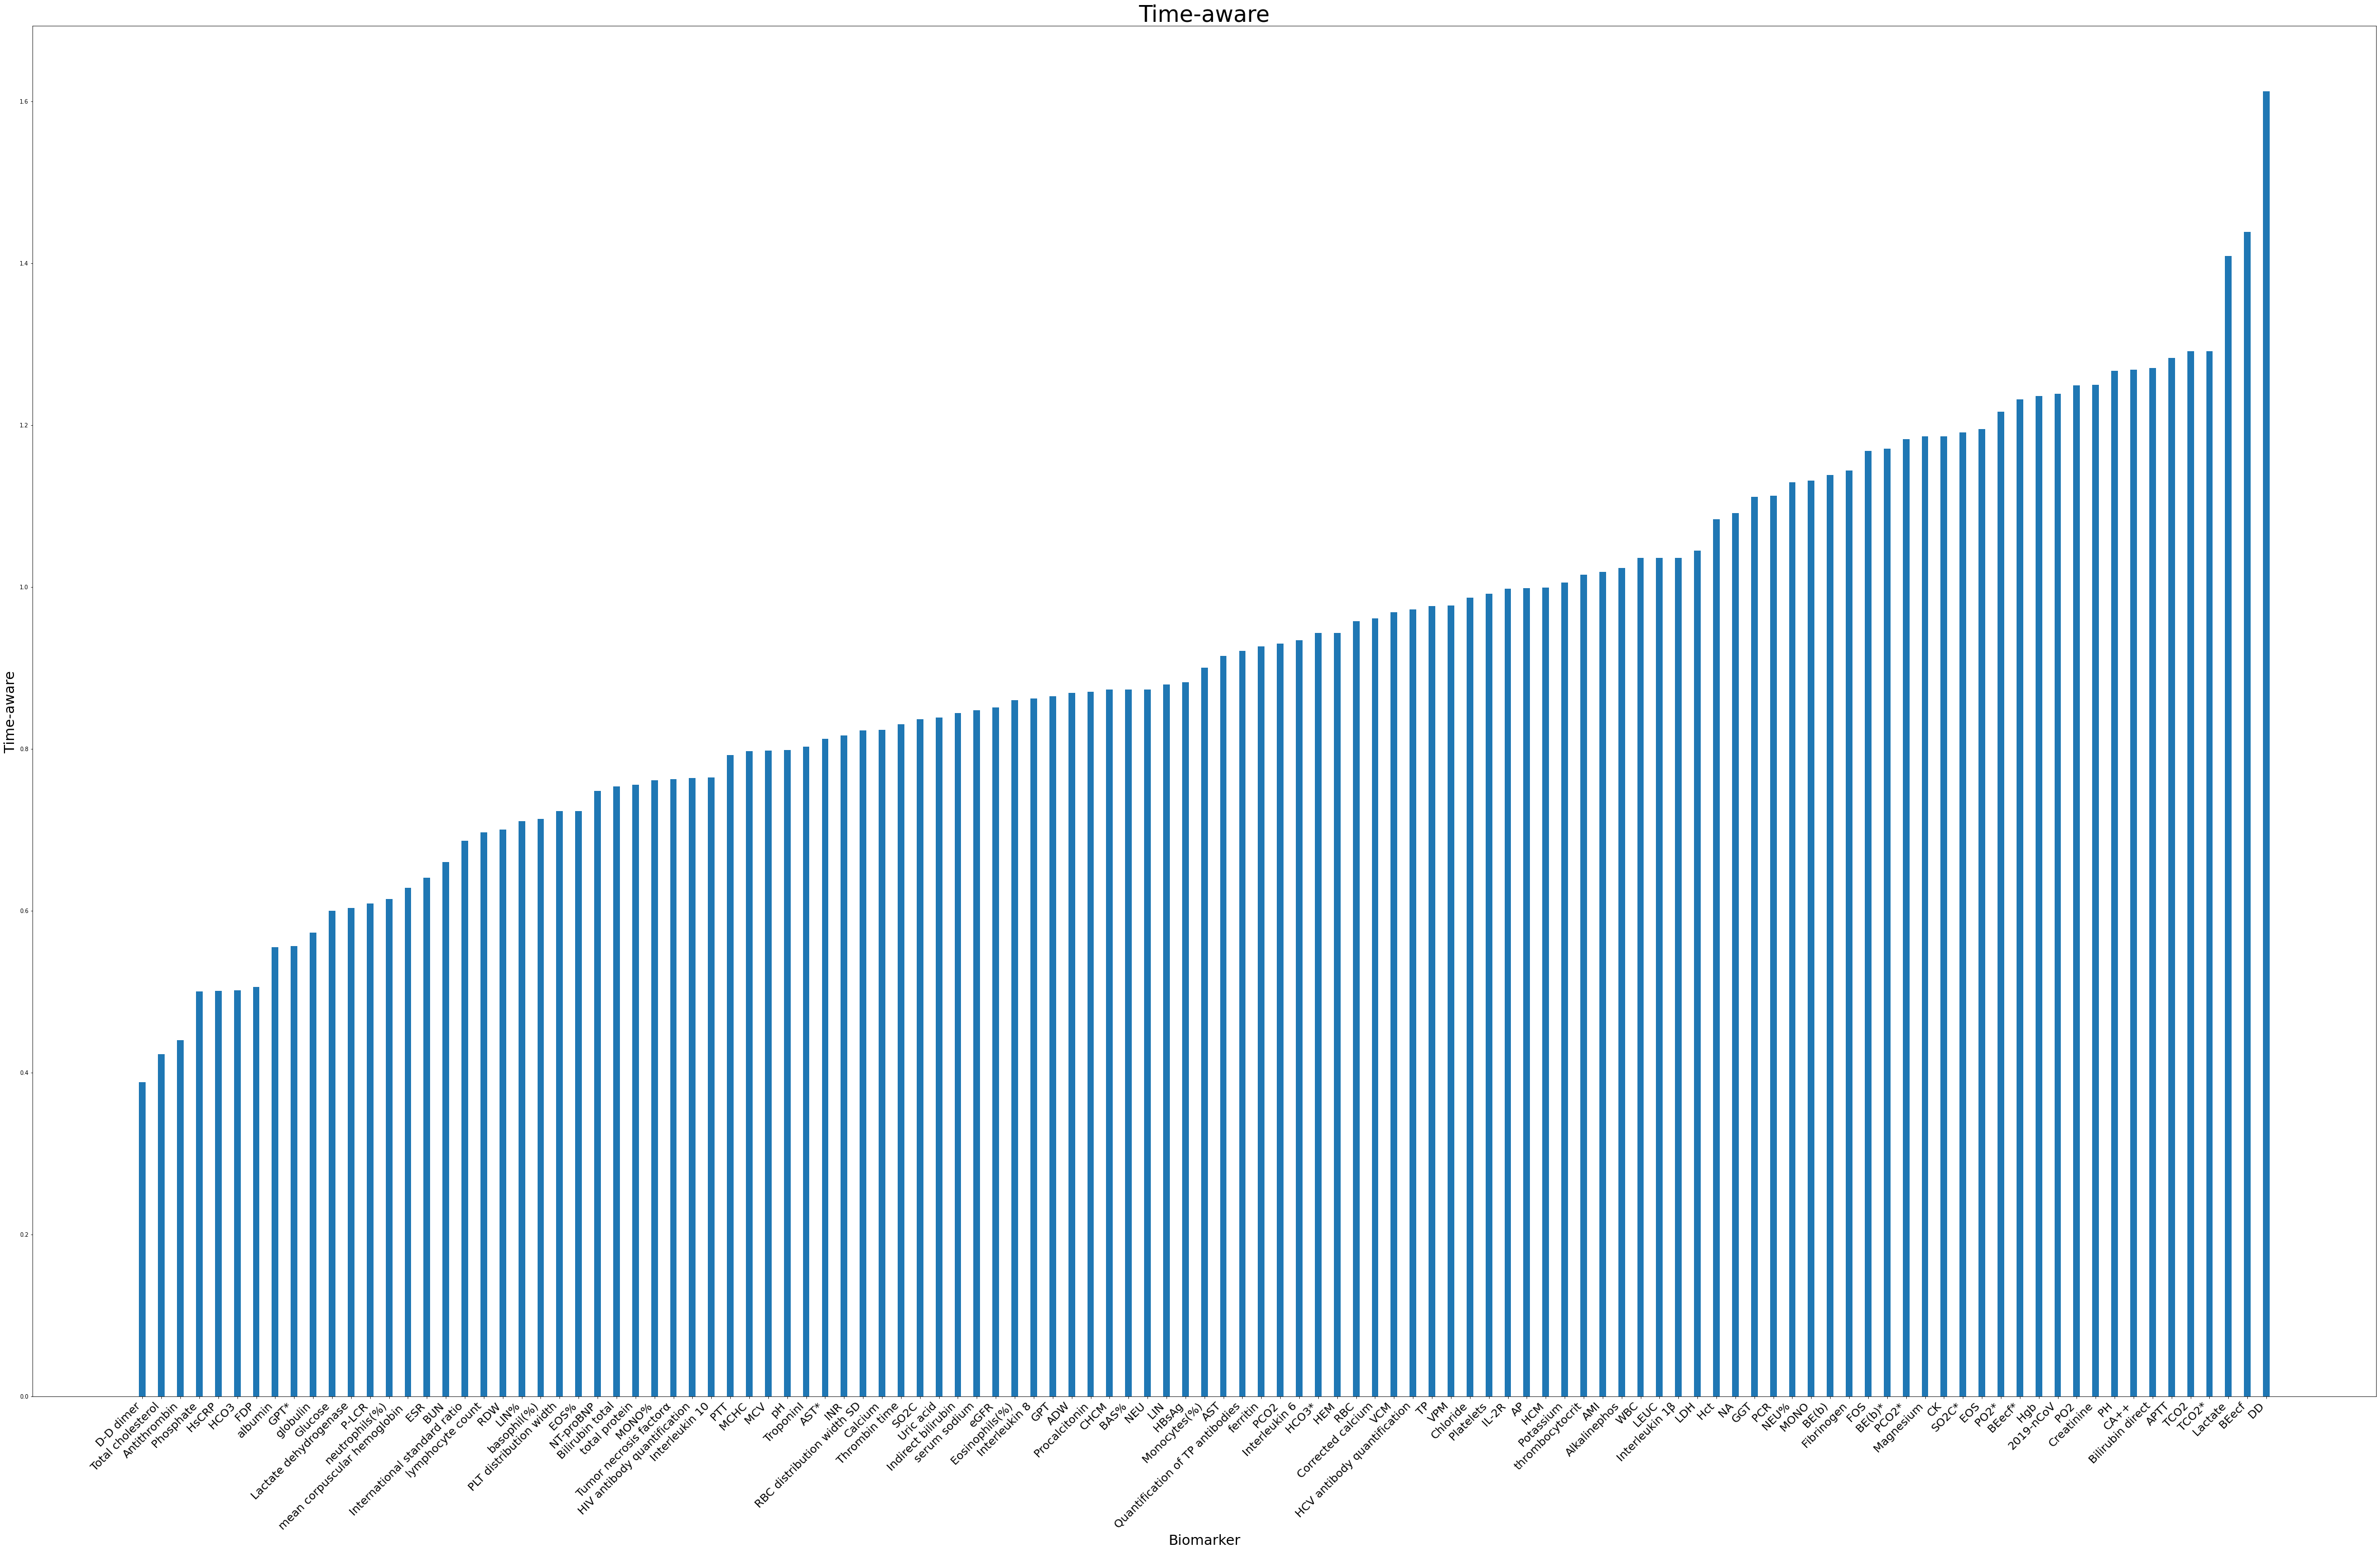

In [57]:
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(75, 45))

ax.bar(idx_list_tongji_spain, time_aware_tongji_spain, width, label='Time-aware')
plt.xticks(rotation=45)
ax.set_xlabel('Biomarker', fontsize=25)
ax.set_ylabel('Time-aware', fontsize=25)

ax.set_xticklabels(idx_list_tongji_spain, fontsize=20, rotation=45, ha='right')

ax.set_title('Time-aware', fontsize=40)
# ax.legend()

figure_fig = plt.gcf()
figure_fig.savefig("prototype_tongji_spain_time_aware_second.pdf", bbox_inches='tight')

## 输出具体患者的 case 分析

In [58]:
def get_n2n_data_mask_patient(x, y, mask, x_len):
    length = len(x)
    assert length == len(y)
    assert length == len(x_len)
    assert length == len(mask)
    
    
    
    new_x = []
    new_y = []
    new_x_len = []
    new_mask = []
    for i in range(length):
#         assert len(x[i]) == len(mask[i])
        new_x.append(list())
        new_y.append(list())
        new_x_len.append(list())
        new_mask.append(list())
        
        if len(x[i]) == 1:
            x[i].append(x[i][-1])
            x_len[i] = x_len[i] + 1
            mask[i].append(mask[i][-1])
            y[i].append(y[i][-1])
        
        
        for j in range(len(x[i])):
            new_x[i].append(x[i][:j+1])
            new_y[i].append(y[i][j])
            new_x_len[i].append(j+1)
            new_mask[i].append(mask[i][j])
    return new_x, new_y, new_mask, new_x_len

In [59]:
x_covid, y_covid, x_mask_covid, x_len_covid = get_n2n_data_mask_patient(all_x_covid, long_y_covid, all_x_mask_global_covid, all_x_len_covid)


In [60]:
pad_token = np.zeros(126)

patient_attns = []
patient_opts = []
patient_zeta_original = []
patient_decay_term = []
y_true_flatten = []
y_pred_flatten = []

In [61]:
# covid ------------------------------------------------------------------------------------------------------------------------
for i in range(len(x_covid)):
    x = list(reversed(x_covid[i]))
    y = list(reversed(y_covid[i]))
    x_len = list(reversed(x_len_covid[i]))
    x_mask = list(reversed(x_mask_covid[i]))
    
    batch_x = torch.tensor(pad_sents(x, pad_token), dtype=torch.float32).to(device)
    batch_y = torch.tensor(y, dtype=torch.float32).to(device)
    batch_lens = torch.tensor(x_len, dtype=torch.float32).to(device).int()
    batch_x_mask = torch.tensor(pad_sents(x_mask, pad_token), dtype=torch.float32).to(device)

    opt, attn,_ , zeta_original, decay_term = model(batch_x, batch_x_mask, batch_lens)
    
    y_pred_flatten += list(opt.cpu().detach().numpy().flatten())
    y_true_flatten += list(batch_y.cpu().numpy().flatten())
    
#     hiddens = list(hiddens.detach().cpu().numpy())
#     patient_hiddens.append(list(reversed(hiddens)))
    attn = list(attn.detach().cpu().numpy())
    patient_attns.append(list(reversed(attn)))
    opt = list(opt.detach().cpu().numpy())
    patient_opts.append(list(reversed(opt)))
    zeta_original = list(zeta_original.detach().cpu().numpy())
    patient_zeta_original.append(list(reversed(zeta_original)))
    decay_term = list(decay_term.detach().cpu().numpy())
    patient_decay_term.append(list(reversed(decay_term)))
    
# covid end --------------------------------------------------------------------------------------------------------------------

/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:213: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:213: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:213: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:213: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:213: UserWarning: Implicit dimension choice for softmax 

In [63]:
visit_attns = []

for i in range(len(patient_attns)):
    for j in range(len(patient_attns[i])):
        visit_attns.append(patient_attns[i][j])


In [64]:
idx_attn = np.array(visit_attns).sum(axis = 0) / len(visit_attns)

In [65]:
idx_visit_attn = {}

for i, idx in enumerate(idx_list):
    if i >= 31 and i < 44:
        continue
    idx_visit_attn[idx] = [visit_attns[v][i] for v in range(len(visit_attns))]





In [68]:
df_attn = pd.DataFrame(idx_visit_attn)
df_attn.describe()

,HCO3,pH,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin direct,Glucose,Potassium,...,PCO2,BEecf,BE(b),TCO2,SO2C,CK,CA++,FOS,AMI,PH
count,6.109000e+03,6.109000e+03,6.109000e+03,6.109000e+03,6.109000e+03,6.109000e+03,6.109000e+03,6.109000e+03,6.109000e+03,6.109000e+03,...,6.109000e+03,6.109000e+03,6.109000e+03,6.109000e+03,6.109000e+03,6.109000e+03,6.109000e+03,6.109000e+03,6.109000e+03,6.109000e+03
mean,1.212762e-05,4.654049e-03,2.415662e-03,7.421889e-03,1.036774e-02,5.735040e-03,6.943434e-03,6.682784e-03,5.182060e-03,7.251561e-03,...,1.219473e-04,1.300522e-04,1.222586e-04,6.090791e-05,2.044367e-04,1.857743e-04,5.465060e-05,1.734169e-04,2.159152e-05,1.170411e-06
std,2.734730e-05,6.696283e-03,3.839612e-03,7.695791e-03,1.103098e-02,6.310744e-03,1.082993e-02,7.238442e-03,5.886344e-03,7.931887e-03,...,1.326353e-03,1.421251e-03,1.330925e-03,8.251757e-04,1.917548e-03,1.856758e-03,7.667005e-04,1.706192e-03,4.058223e-04,6.279178e-05
min,5.320702e-13,1.490346e-10,1.653882e-10,2.610536e-11,9.357911e-11,1.274993e-10,3.223912e-07,1.666191e-12,2.590483e-08,2.018813e-11,...,4.110664e-17,7.479338e-18,5.126744e-17,8.952280e-18,1.167615e-17,1.689692e-17,2.150614e-18,3.963455e-17,1.752385e-15,5.186244e-18
25%,3.457685e-08,1.209347e-05,3.694189e-05,3.399774e-05,3.645747e-05,3.957014e-05,1.144572e-03,1.558186e-05,3.335793e-04,2.516155e-05,...,6.412382e-12,2.352182e-12,9.269227e-12,1.868627e-12,2.313907e-12,2.922673e-12,1.407533e-12,5.278638e-12,7.415935e-11,1.172925e-12
50%,2.494897e-07,1.528926e-03,1.340025e-03,2.819414e-03,2.660559e-03,2.004574e-03,3.366974e-03,2.228102e-03,3.029792e-03,2.480923e-03,...,7.245087e-10,6.648928e-10,1.387145e-09,2.255386e-10,4.248704e-10,8.357675e-10,3.424372e-10,6.941857e-10,6.813646e-09,3.363506e-10
75%,1.270029e-05,6.797618e-03,3.085329e-03,1.558148e-02,2.149117e-02,1.223779e-02,8.280104e-03,1.452090e-02,8.706803e-03,1.455824e-02,...,3.147833e-07,1.286342e-07,2.664194e-07,7.554174e-08,3.022501e-07,2.806070e-07,6.101008e-08,3.886961e-07,7.864149e-07,2.666245e-08
max,3.690852e-04,1.033137e-01,4.097715e-02,3.093303e-02,4.270697e-02,3.083693e-02,2.028607e-01,2.595602e-02,6.845080e-02,9.340588e-02,...,1.706658e-02,1.929745e-02,1.814720e-02,1.211477e-02,2.687911e-02,3.287833e-02,1.493667e-02,2.296171e-02,8.686743e-03,3.637776e-03


### 筛选 case

In [69]:
tongji_idx_miss = pickle.load(open('./data/all_tongji_idx_miss.dat', 'rb'))

In [70]:
tongji_idx_miss_sort = []

for i in range(len(tongji_idx_miss)):
    tongji_idx_miss_sort.append([])
    cur_mask = np.array(tongji_idx_miss[i])
    cur_block5_mask = cur_mask[:, covid_block5]
    cur_block2_mask = cur_mask[:, covid_block2]
    cur_block6_mask = cur_mask[:, covid_block6]
    cur_block3_mask = cur_mask[:, covid_block3]
    
    add_block4_mask = [[0] * 3] * len(all_x_mask_covid[i])
    add_block1_mask = [[0] * 13] * len(all_x_mask_covid[i])
    add_block7_mask = [[0] * 36] * len(all_x_mask_covid[i])
    
    tongji_idx_miss_sort[i] = np.concatenate((cur_block5_mask, cur_block2_mask, 
                                     add_block4_mask, cur_block6_mask, 
                                     add_block1_mask, cur_block3_mask,
                                     add_block7_mask
                                    ), axis=1).tolist()  
    
    
        

In [71]:
for p_i, p_attn in enumerate(patient_attns):
    if len(patient_attns) < 6:
        continue
    for v_i, v_attn in enumerate(p_attn):
        if len(p_attn) - v_i < 6:
            continue
        for idx_i, idx_attn in enumerate(v_attn):
            if idx_i >= 31 and idx_i < 44:
                continue
            if idx_attn > 1.2e-1 and tongji_idx_miss_sort[p_i][v_i][idx_i] == '1' and \
            tongji_idx_miss_sort[p_i][v_i + 1][idx_i] == '0' and \
            tongji_idx_miss_sort[p_i][v_i + 2][idx_i] == '0' and \
            tongji_idx_miss_sort[p_i][v_i + 3][idx_i] == '0' and \
            tongji_idx_miss_sort[p_i][v_i + 4][idx_i] == '0' and \
            tongji_idx_miss_sort[p_i][v_i + 5][idx_i] == '0':
                print(p_i, ', ', v_i, ', ', idx_list[idx_i])
                
    

1 ,  5 ,  eGFR
1 ,  11 ,  Platelets
1 ,  11 ,  thrombocytocrit
1 ,  19 ,  lymphocyte count
1 ,  19 ,  thrombocytocrit
1 ,  21 ,  Total cholesterol
2 ,  4 ,  eGFR
2 ,  9 ,  Platelets
2 ,  9 ,  LIN%
4 ,  3 ,  eGFR
4 ,  9 ,  Platelets
4 ,  9 ,  lymphocyte count
5 ,  1 ,  Monocytes(%)
5 ,  3 ,  albumin
6 ,  2 ,  AP
7 ,  11 ,  Eosinophils(%)
7 ,  11 ,  Monocytes(%)
7 ,  11 ,  lymphocyte count
8 ,  0 ,  Monocytes(%)
8 ,  2 ,  eGFR
9 ,  11 ,  thrombocytocrit
9 ,  12 ,  AP
9 ,  20 ,  AP
10 ,  4 ,  eGFR
11 ,  0 ,  Monocytes(%)
11 ,  4 ,  albumin
12 ,  2 ,  albumin
12 ,  10 ,  LIN%
12 ,  10 ,  lymphocyte count
13 ,  2 ,  Eosinophils(%)
13 ,  15 ,  LIN%
13 ,  15 ,  lymphocyte count
13 ,  16 ,  TroponinI
15 ,  0 ,  Platelets
15 ,  0 ,  Monocytes(%)
16 ,  0 ,  Platelets
16 ,  2 ,  albumin
16 ,  2 ,  Total cholesterol
16 ,  2 ,  eGFR
16 ,  16 ,  lymphocyte count
16 ,  16 ,  thrombocytocrit
17 ,  3 ,  thrombocytocrit
18 ,  0 ,  Monocytes(%)
18 ,  11 ,  LIN%
18 ,  11 ,  Monocytes(%)
19 ,  12 ,  AP
19 

In [121]:
pdid = 176
start_vid = 2
idxid = idx_list.index('eGFR')

outcome = 'alive'
if kfold_y_covid[pdid] == 1:
    outcome = 'dead'
    

print('patient ', pdid, '\toutcome:', outcome, '\t idx:', idx_list[idxid], '\t time-aware: second')

print('\ntime diff \t attn \t zeta_original \t decay_term')
print('-----------------------------------------------------')
for vid in range(start_vid, start_vid + 6):
    print('%.2fh: \t\t %.2f%% \t %.3f \t %f' %(all_x_mask_global_covid[pdid][vid][idxid]/60/60, patient_attns[pdid][vid][idxid]*100, patient_zeta_original[pdid][vid][idxid], patient_decay_term[pdid][vid][idxid] ))   

patient  176 	outcome: alive 	 idx: eGFR 	 time-aware: second

time diff 	 attn 	 zeta_original 	 decay_term
-----------------------------------------------------
0.00h: 		 14.48% 	 12.570 	 0.000000
1.07h: 		 15.35% 	 12.865 	 0.008523
1.13h: 		 15.23% 	 13.148 	 0.006594
5.57h: 		 14.82% 	 13.364 	 0.026014
14.33h: 		 14.02% 	 13.492 	 0.060577
77.20h: 		 13.20% 	 13.562 	 0.264315


0